## 🔧 Code guidelines:
- Please follow python coding convention "e.g. imports are alphabetically sorted".
- Use python type hinting for increased readability of your code.
- Please add any helper functions in the helper functions block.
- It is preferred to implement one-time-local-helper-functions inside your parent function.

## 🦦 Managing virtual environments:
```Console
*** Mac:
$ python3 -m venv venv
$ source venv/bin/activate
$ pip3 install -r requirements.txt
$ pip3 freeze > requirements.txt 
$ deactivate

*** Mac:
$ python -m venv venv
$ venv\Scripts\activate.bat
$ pip install -r requirements.txt
$ pip freeze > requirements.txt 
$ deactivate
```

In [1]:
import cv2
import os, csv
import imutils
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.measure
from skimage.morphology import binary_erosion
from typing import Final


In [164]:
# Extra Import

import warnings

warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
# [0]: Add helper functions here
def show_images(images, titles=None):
    """Display a list of images in a single figure with matplotlib."""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images,titles), start=1):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

# Crop Number Plate

In [131]:
# [1]: Crop Number Plate
def crop_image(image: np.ndarray): #-> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 170
    CANNY_THRESH_HIGH: Final[int] = 200
    BILATERAL_FILTER_SIZE: Final[int] = 11
    BILATERAL_FILTER_SIGMA_COLOR: Final[int] = 17
    BILATERAL_FILTER_SIGMA_SPACE: Final[int] = 17
    MAX_NUM_CONTOURS: Final[int] = 30
    # [1]: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # [2]: Reduce noise and preserve edges
    gray = cv2.bilateralFilter(
        gray, 
        BILATERAL_FILTER_SIZE, 
        BILATERAL_FILTER_SIGMA_COLOR, 
        BILATERAL_FILTER_SIGMA_SPACE
    )
    # [3]: Edge Detection
    edges = cv2.Canny(gray, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [4]: Find contours && sort by their area
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:MAX_NUM_CONTOURS]
    # [5]: Find contour with 4 corners
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return gray[y:y+h, x:x+w]
    temp=[
        get_image(c)
        for c in contours 
        if cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True).shape[0] == 4
    ]
    return temp[0] if temp else []

# Rotate Image

In [4]:
# [2]: Skew Rotation Correction
def rotate_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 0
    CANNY_THRESH_HIGH: Final[int] = 100
    # [2]: Edge Detection
    edges = cv2.Canny(image, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [3]: Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    # [4]: Find most common angle
    angle = np.degrees(max(
        (line[0][1] for line in lines), 
        key=lambda x: list(lines[:,0,1]).count(x)
    ))
    # [5]: Rotate the image
    return sk.transform.rotate(
        image,
        angle+90 if angle<0 else angle-90
    )

# Character Segmentation

In [82]:
# [3]: Character Segmentation
def segment_Character(image: np.ndarray) -> np.ndarray:
    image_out = np.zeros(image.shape)
    # [1]: Threshold Image using OTSU for automatic thresholding
    Threshold = sk.filters.threshold_otsu(image)
    image_out[image <= Threshold] = 1
    # show_images([ image_out])

    # [2]: Detect Contours around each character
    contours = sk.measure.find_contours(image_out, 0.8)
    bounding_boxes = []
    for contour in contours:
        startY, endY = min(contour[:, 0]), max(contour[:, 0])
        startX, endX = min(contour[:, 1]), max(contour[:, 1])
        ratio = (endY-startY)/(endX-startX)
        if(1 < ratio < 3):
            tup = map(int, np.round((startX, endX, startY, endY)))
            endY-startY > 5 and endX - \
                startX > 5 and bounding_boxes.append(tuple(tup))

    # [3]: Sort the boundring boxes to make sure that the characters are drawin in the right order
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])

    # [4] : Draw a Box surrounding the character
    img_with_boxes = np.copy(image)  # np.zeros(image.shape)
    # When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = sk.draw.rectangle_perimeter(
            start=(Ymin, Xmin), end=(Ymax, Xmax), shape=image.shape)
        img_with_boxes[rr, cc] = 1  # set color white
    Xmin, Xmax, Ymin, Ymax = bounding_boxes[1]
    # print(image[Ymin:Ymax,Xmin,Xmax])

    # [5]: create a list of images cropped images for each character
    character_Image_list = []
    CHARACTER_PADDING_X: Final[int] = 2
    CHARACTER_PADDING_Y: Final[int] = 2
    for box in bounding_boxes:
        character = image_out[box[2]-CHARACTER_PADDING_Y:box[3] +
                              CHARACTER_PADDING_Y, box[0]-CHARACTER_PADDING_X:box[1]+CHARACTER_PADDING_X]
        character_Image_list.append(character)

    # show_images(character_Image_list)
    # for i in range(len(character_Image_list)):
    #     plt.subplot(1, len(character_Image_list), i+1)
    #     plt.imshow(character_Image_list[i], cmap='gray')
    #     plt.axis('off')
    # plt.show()

    # ---> List of boxes for each character
    return character_Image_list


# Character Recognition | Template Matching

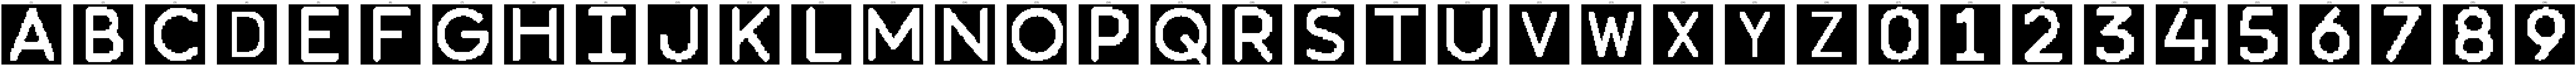

In [6]:
# Get Characters
import os

Characters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

CharTemplate = []

# read all files in template folder and store them in CharTemplate
for index, char in enumerate(Characters):
    CharTemplate.append((sk.io.imread('templates/'+char+'.jpg') > 200).astype(np.uint8)*255)
show_images(CharTemplate)


In [7]:
# [4]: Character reconigtion

def calculateTheEuclideanDistance(image1, image2):
    # sum of absolute differences between the pixels of the two images
    return np.linalg.norm(image1.flatten()-image2.flatten())

def calculateTheCrossCorrelation(image1, image2):
    # Calculate the cross correlation between two images
    # The cross correlation is the sum of the product of the pixels of the two images
    return np.sum(image1*image2)

def calculateTheNormalizedCrossCorrelation(image1, image2):
    # Calculate the normalized cross correlation between two images
    # The normalized cross correlation is the sum of the product of the pixels of the two images divided by the product of the standard deviations of the two images
    return np.sum(image1*image2)/(np.std(image1)*np.std(image2))

def getMaxIndex(list):
    max = 0
    index = 0
    for i in range(len(list)):
        if list[i] > max:
            max = list[i]
            index = i
    return index

def characterRecognition (license):
    text = ''
    
    for charac in license:
        # resize image
        charac= charac.astype(np.int8)*255
        charac = sk.transform.resize(charac, (48, 48))
        charac = (charac*255).astype(np.int8)

        templateMatchingValues = []

        for i in range (len(CharTemplate)):
            crossCorrelation = calculateTheCrossCorrelation(charac, CharTemplate[i])
            euclideanDistance = calculateTheEuclideanDistance(CharTemplate[i],charac)
            normalizedCrossCorrelation = calculateTheNormalizedCrossCorrelation(CharTemplate[i],charac)
            templateMatchingValues.append(crossCorrelation/(euclideanDistance + normalizedCrossCorrelation) )
        text += Characters[getMaxIndex(templateMatchingValues)]

    return text
    

# CharacterRecognition | KNN

### Imports 


In [157]:

import numpy as np

import matplotlib.pyplot as plt

import cv2 as cv

import os
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

## Import Dataset

In [158]:
# dir_path = 'CNN letter Dataset'
dir_path = 'Train'
digits = sorted(os.listdir(dir_path))
digitLetter=[digit[-1] for digit in digits]
NUM_CLASSES = len(digits)

print(digits)
print('Number of classes (letters and digits): ', NUM_CLASSES)

digits_counter = {}
NUM_IMAGES = 0

for digit in digits:
    path = os.path.join(dir_path, digit)
    digits_counter[digit] = len(os.listdir(path))
    NUM_IMAGES += len(os.listdir(path))

print(digits_counter)
print('Number of all images: ', NUM_IMAGES)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']
Number of classes (letters and digits):  36
{'class_0': 24, 'class_1': 24, 'class_2': 24, 'class_3': 24, 'class_4': 24, 'class_5': 24, 'class_6': 24, 'class_7': 24, 'class_8': 24, 'class_9': 24, 'class_A': 24, 'class_B': 24, 'class_C': 24, 'class_D': 24, 'class_E': 24, 'class_F': 24, 'class_G': 24, 'class_H': 24, 'class_I': 24, 'class_J': 24, 'class_K': 24, 'class_L': 24, 'class_M': 24, 'class_N': 24, 'class_O': 24, 'class_P': 24, 'class_Q': 24, 'class_R': 24, 'class_S': 24, 'class_T': 24, 'class_U': 24, 'class_V': 24, 'class_W': 24, 'class_X': 24, 'class_Y': 24, 'class_Z': 24}
Number of all imag

### Check Sample of TestData

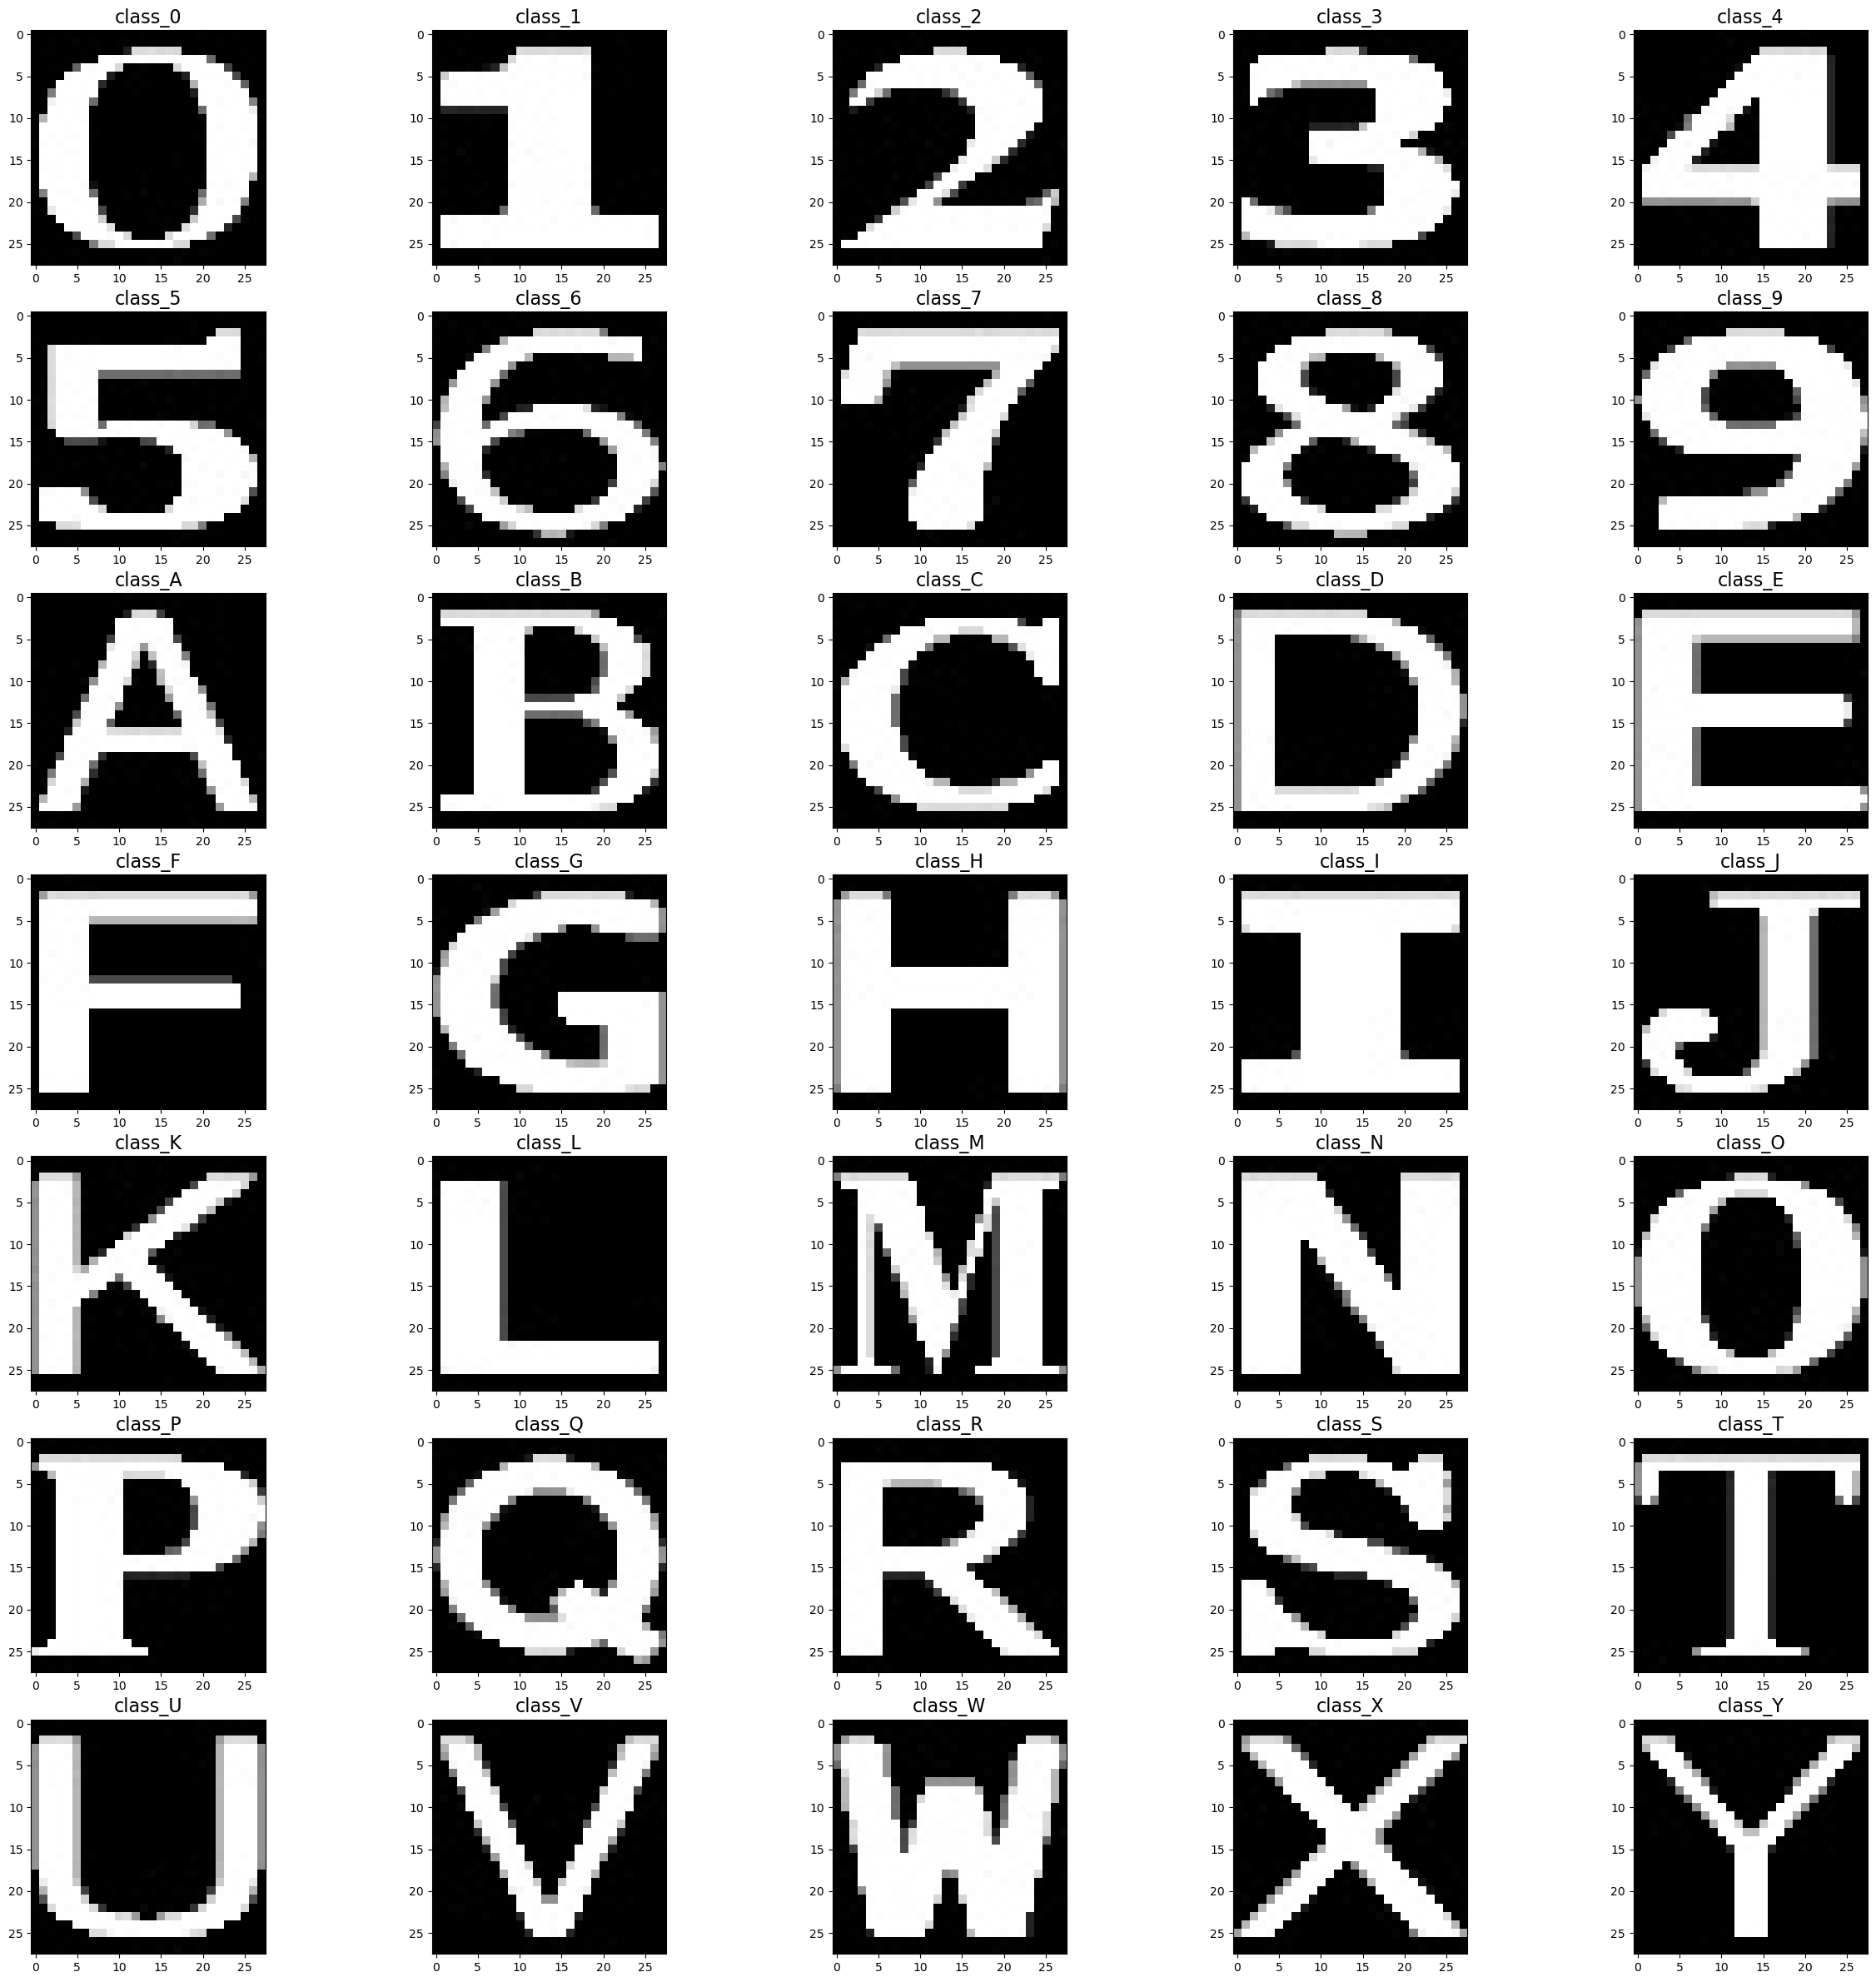

In [159]:
rows, columns = 7, 5

k = 0
fig, axes = plt.subplots(rows, columns, figsize=(30, 30))
for row in range(rows):
    for column in range(columns):
        rand_num = np.random.randint(0, digits_counter[digits[k]])
        class_path = dir_path + '/' + str(digits[k])
        image_path = class_path + '/' + str(os.listdir(class_path)[rand_num])
        ax = axes[row, column]
        ax.set_title(digits[k], loc='center', fontsize=16)
        ax.imshow(imread(image_path), cmap='gray')
        k += 1
plt.show()

### Prep For Train

In [160]:
data = []
labels = []
MAX_NUM = None   # maximum number of digits images per class
IMG_WIDTH, IMG_HEIGHT = 35, 45

# images of digits '6' in folder with '2'
incorrect_img = [
    'aug20121_0.jpg',
    'aug20122_1.jpg',
    'aug20123_2.jpg',
    'aug20124_3.jpg',
    'aug20125_4.jpg',
    'aug20126_5.jpg',
    'aug20127_6.jpg',
    'aug20128_7.jpg',
    'aug20129_8.jpg',
    'aug20130_9.jpg'
]

for digit in digits:
    path = os.path.join(dir_path, digit)
    label = digits.index(digit)
    for img in os.listdir(path):
        if img in incorrect_img:
            continue
        img_path = os.path.join(path, img)
        img_array = cv.imread(img_path)
        resized = cv.resize(img_array, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
        gray = cv.cvtColor(resized, cv.COLOR_RGB2GRAY)        
        data.append(gray)
        labels.append(label)
        if MAX_NUM is not None:
            if labels.count(label) == MAX_NUM:
                break

data = np.array(data, dtype='float32')
labels = np.array(labels, dtype='int8')
print(data.shape)


(864, 45, 35)


In [161]:

data = data / 255.0
# data = data.reshape(*data.shape, 1)
print(data.shape)
print(labels.shape)

(864, 45, 35)
(864,)


## Split DataSet

In [162]:

from sklearn.model_selection import train_test_split
nsamples, nx, ny = data.shape
d2_train_dataset = data.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(d2_train_dataset, labels, test_size=0.25)



## Train Model

In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# create an instance of the classifier
knn_default = KNeighborsClassifier(n_neighbors=5)
# fit the model and perform cross validation
knn_default.fit(X_train, y_train)
cv_scores = cross_val_score(knn_default, X_train, y_train, cv=5, scoring="accuracy")
# take the average of the scores of different folds
knn_default.fit(X_train, y_train)  
final_score_default = np.mean(cv_scores)
print("Accuracy with defaul KNN:", final_score_default)


Accuracy with defaul KNN: 0.9444484197972571


In [50]:
print(labels[2+(12*100)])

12


# Testing

### First Basic Tests

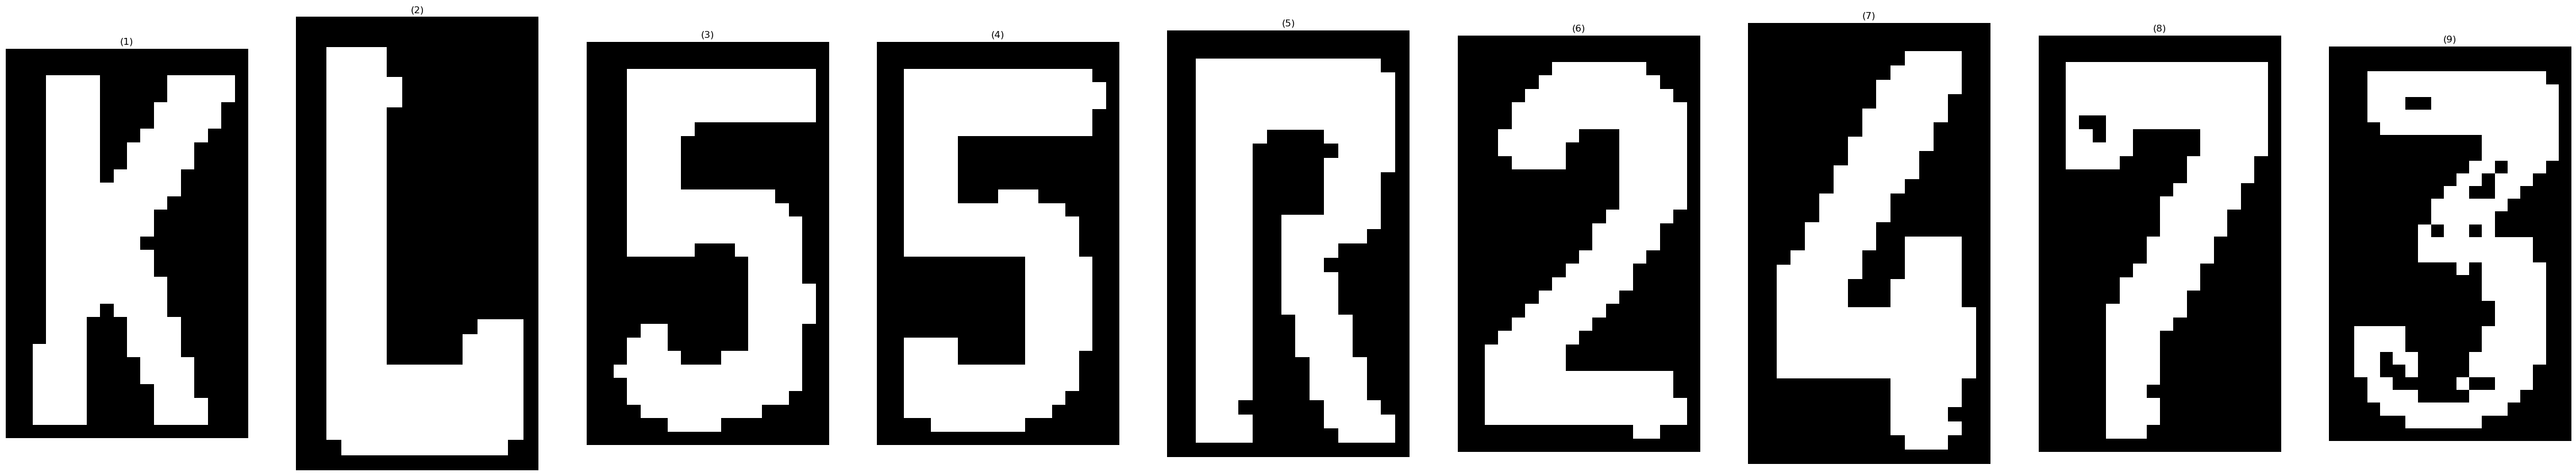

In [85]:
car1_image = cv2.imread('./test_dataset/images/1.jpg')
car2_image = cv2.imread('./test_dataset/images/2.jpg')
car3_image = cv2.imread('./test_dataset/images/3.jpg')
cars=[car1_image,car2_image,car3_image]
#show_images(cars, ["Input Image1","Input Image2","Input Image"])

cars_image_cropped = [crop_image(car) for car in cars]
#show_images(cars_image_cropped, ["Car Image Cropped","Car Image Cropped","Car Image Cropped"])

car_image_rotated = [rotate_image(car) for car in cars_image_cropped]
# show_images(car_image_rotated, ["Car Image Rotated","Car Image Not Rotated","Car Image Rotated2"])

chars = [segment_Character(car) for car in car_image_rotated]
# for i in range(len(chars)): show_images(chars[i])
test0=chars[0]


show_images(test0)

# for i in range(len(chars)): print(characterRecognition(chars[i]))


### Test KNN of Specific Image

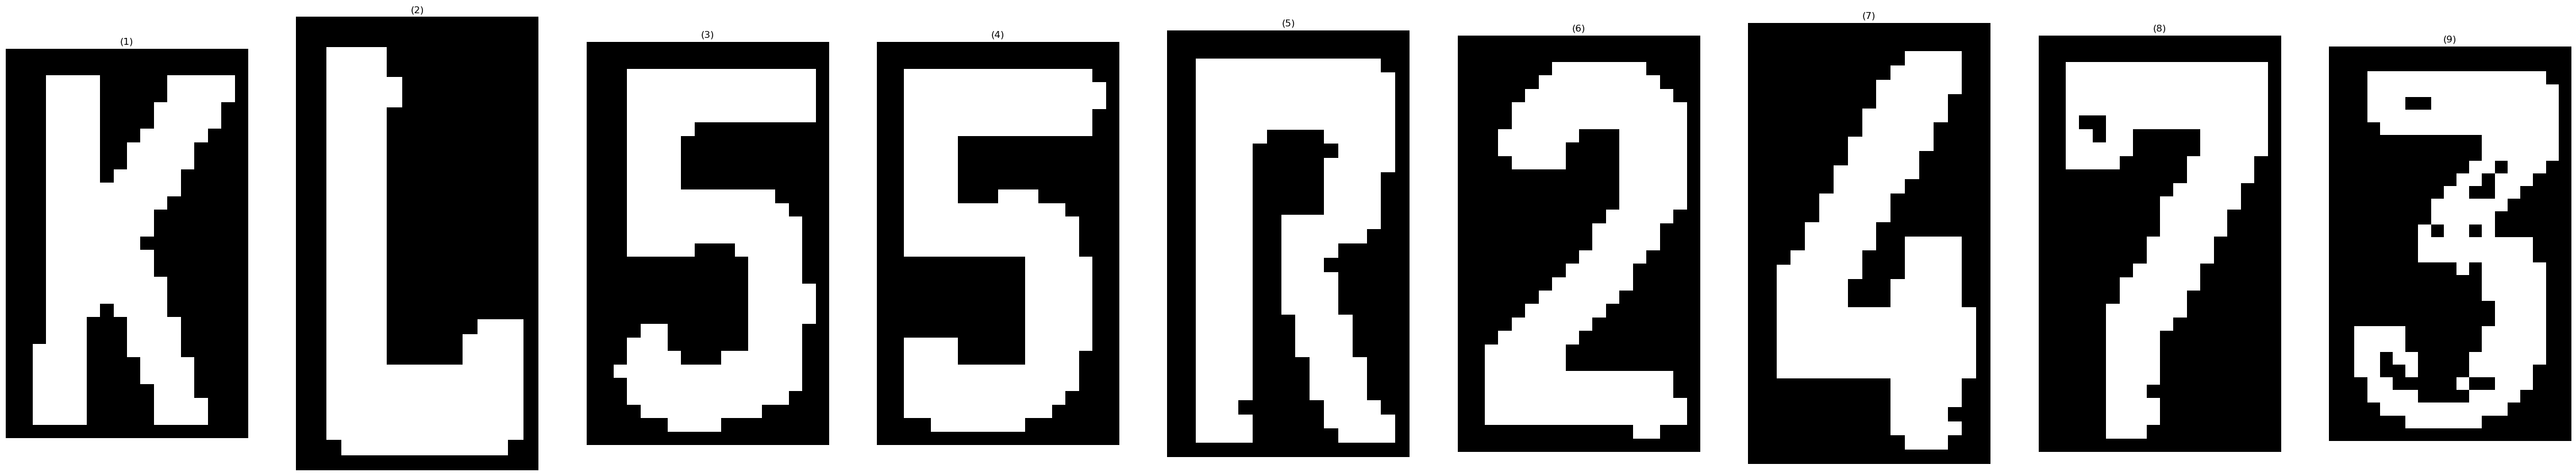

KL55R2473


In [166]:

data2=""
show_images(test0)
for img in test0:
    # print(img)
    new_img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
    new_img = new_img.reshape((1,IMG_WIDTH*IMG_HEIGHT))
    # print(new_img.shape)
    y_prediction = knn_default.predict(new_img)
    # print(digitLetter[int(y_prediction)])
    data2+=digitLetter[int(y_prediction)]
print(data2)
# for i in range(len(chars)): show_images(chars[i])
# accuracy=np.mean(y_prediction == y_test)*100
# print("The achieved accuracy using Decision Tree is " + str(accuracy))

### Read Test Data

In [9]:
# read the test data to test from csv file
with open('test_dataset\labels.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    test_plates={}
    next(reader)
    for row in reader:
        test_plates[row[0]]=row[1] 
        
print(test_plates)

{'1': 'KL55R2473', '2': 'GJW115A1138', '3': 'KL16J3636', '4': 'MH20EE7598', '5': 'PJJ1L76', '6': 'HR26DA2330', '7': 'HR268P3543', '8': 'HR26CT6Y02', '9': 'KL01BR8055', '10': 'KL7BZ99', '11': 'FAD3Z97', '12': 'MH12JC2813', '13': 'MH14EU3498', '14': 'HR26CT6702', '15': 'GAR1P11', '16': 'PGMN112', '17': 'DZ17YXR', '18': 'ENY8N06', '19': 'BAD231', '20': 'PGMN112', '21': '15LK10898', '22': 'YYD6B61', '23': 'PGMN112', '24': 'JQJ4S58', '25': 'G241GH', '26': '7XFT96', '27': 'IYZ2Z18', '28': 'JET7G88', '29': 'THY7E19', '30': 'UKV4L15', '31': 'VYS7A51', '32': 'VDU7V67', '33': 'BG04L12', '34': 'BAV9R93', '35': 'UZ08070', '36': 'KJE1I58', '37': 'VEI2H47', '38': 'CRF4E69', '39': 'PUX5E62', '40': 'ZKR5V97', '41': 'FPK3Q88', '42': 'HKU2A19', '43': 'XJR2P46', '44': 'LLZ6Y18', '45': 'EDE7H27', '46': 'FYJ4H11', '47': 'BZY8Z87', '48': 'GAR1P11', '49': 'LPQ5G75', '50': 'FKA4V49', '51': 'UH07B94', '52': 'UJV9N75', '53': 'K0Z9P76', '54': 'YUT1X16', '55': 'UUZ7A01', '56': 'X0S9J87', '57': 'XXQ8T08', '58': 'K

In [146]:
for path, dirs, files in os.walk("test_dataset/images/"):
    car_names=[]
    for filename in files:
        car_names.append(filename)
car_names=sorted(car_names, key=lambda x: int(x[:-4]))
print(car_names)    

print(test_plates[car_names[0][:-4]],len(car_names))

cars={car[:-4]:car for car in car_names}
cars ={ car:filename for car,filename in cars.items() if(int(car)<=100)  }
print(cars)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '12.jpg', '13.jpg', '14.jpg', '15.JPG', '16.jpg', '17.jpg', '19.jpg', '20.jpg', '21.jpg', '24.JPG', '27.JPG', '28.JPG', '30.JPG', '31.JPG', '32.JPG', '33.JPG', '34.JPG', '35.JPG', '36.JPG', '37.JPG', '38.JPG', '39.JPG', '42.JPG', '44.JPG', '46.JPG', '47.JPG', '48.JPG', '49.JPG', '50.JPG', '51.JPG', '52.JPG', '54.JPG', '55.JPG', '56.JPG', '57.JPG', '58.JPG', '59.JPG', '60.JPG', '61.JPG', '62.JPG', '63.JPG', '64.JPG', '66.JPG', '68.JPG', '69.JPG', '70.JPG', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.JPG', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.png', '86.JPG', '87.JPG', '88.JPG', '89.JPG', '90.JPG', '91.JPG', '92.JPG', '94.jpg', '95.JPG', '96.JPG', '98.JPG', '99.JPG', '100.JPG', '103.JPG', '104.JPG', '105.JPG', '108.JPG', '109.JPG', '110.JPG', '112.JPG', '113.JPG', '114.JPG', '116.JPG', '117.JPG', '118.JPG', '119.JPG', '120.JPG', '121.JPG', '122.JPG', '123.JPG',

### Test the Test Data

In [138]:
ignoreImage=[ '19.jpg','30.JPG', '62.JPG', '64.JPG','66.JPG']
ignoreFromCropp=[]

1.jpg


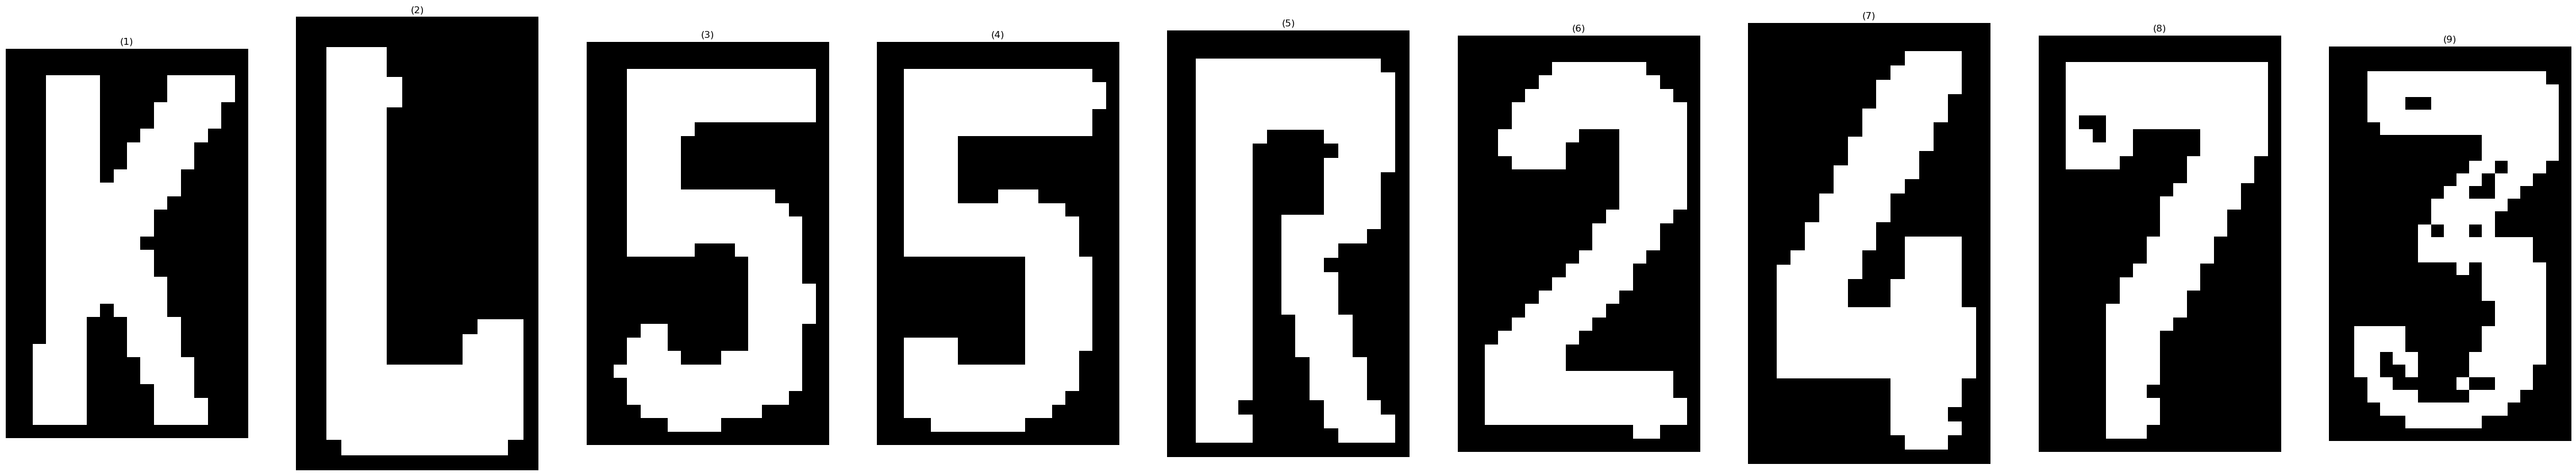

KL55R2473
2.jpg


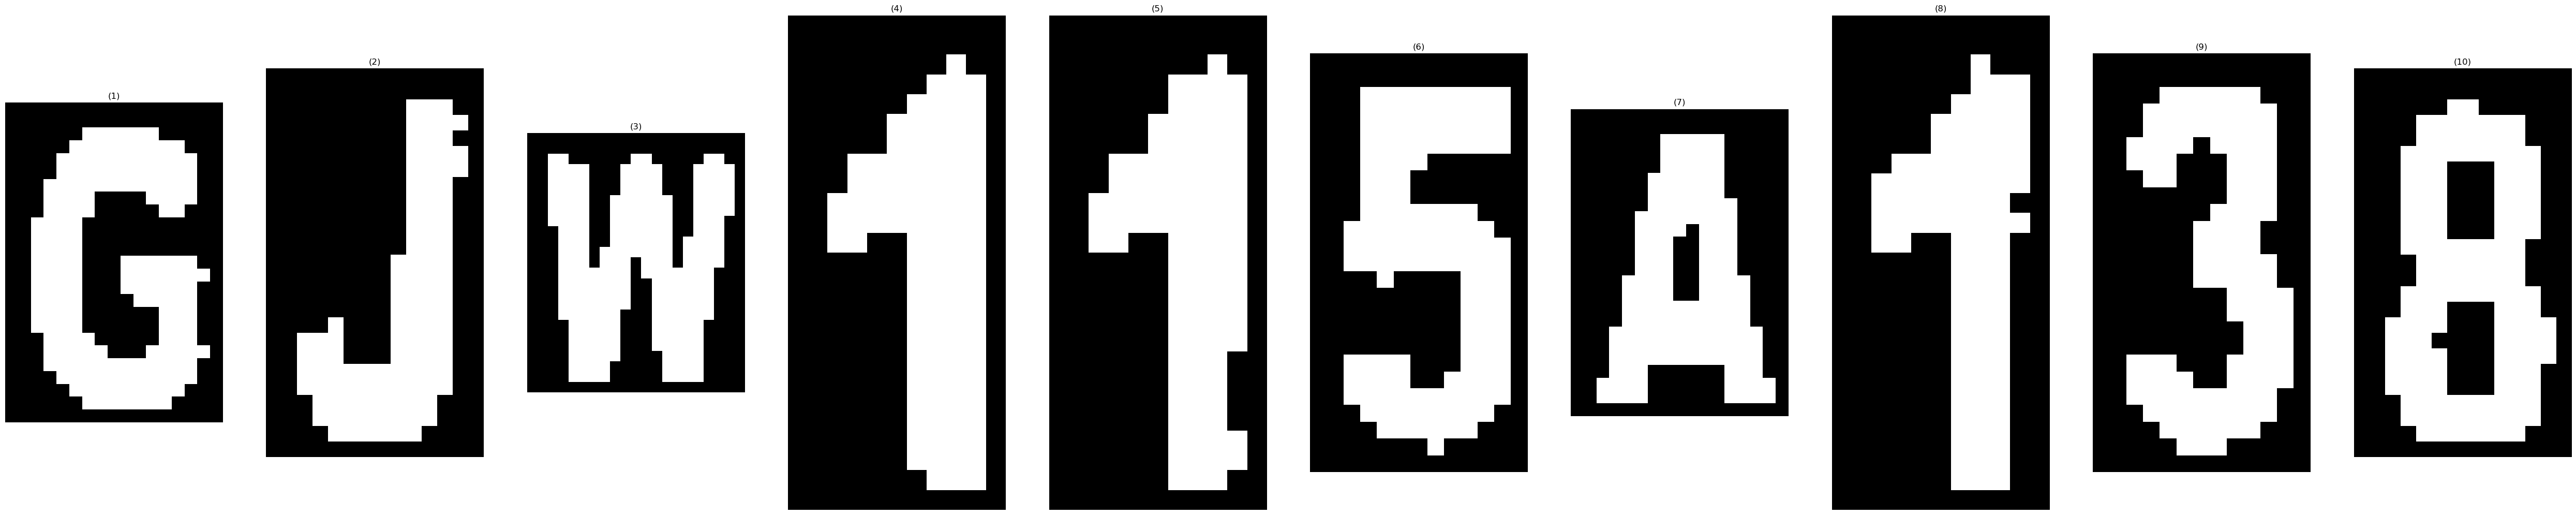

GJW115A138
3.jpg


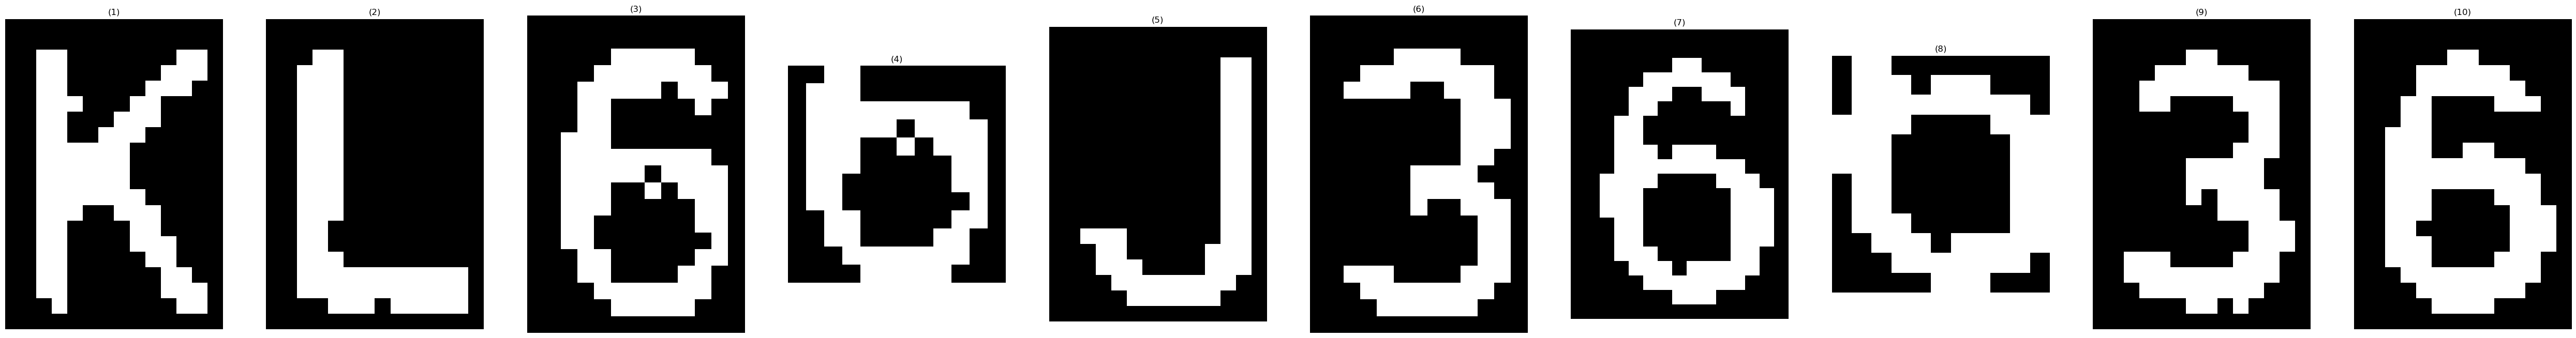

KL60J36O36
4.jpg


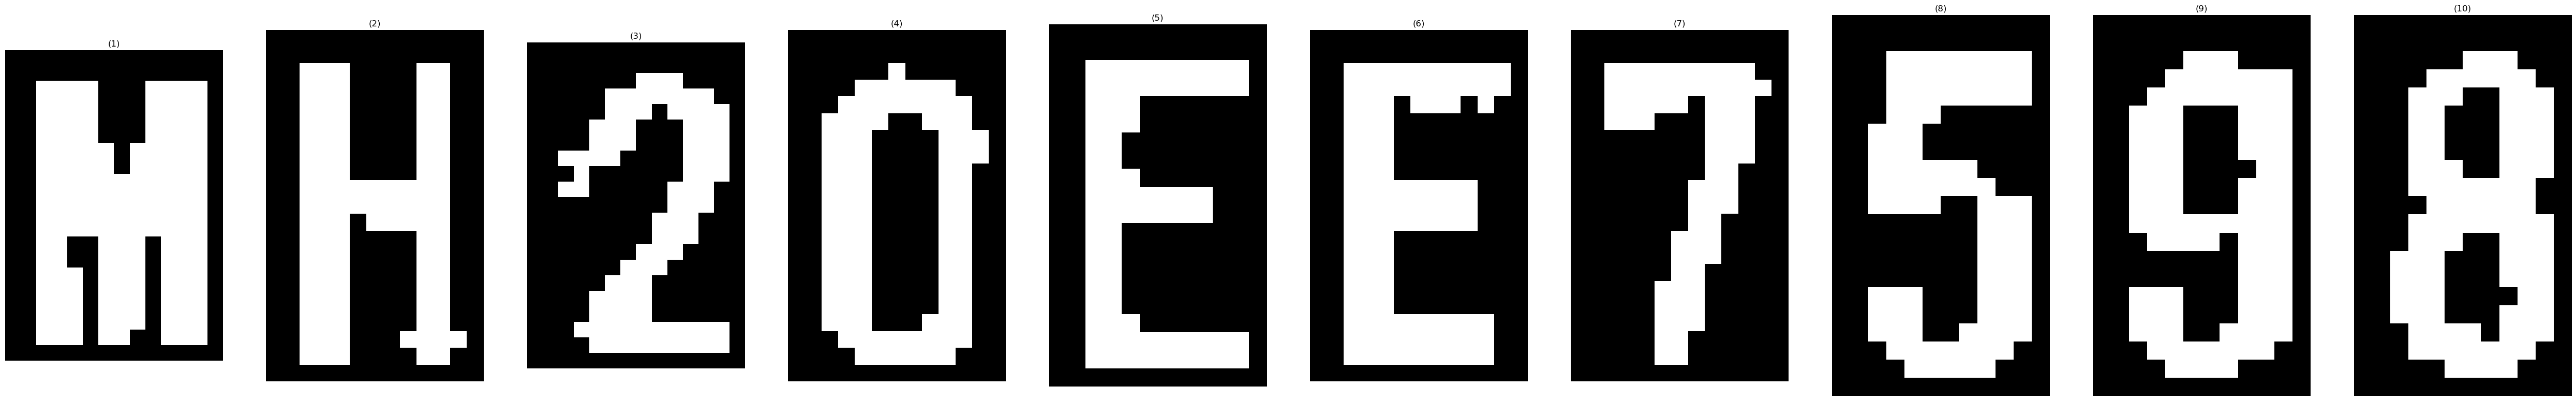

8H20EE7598
6.jpg


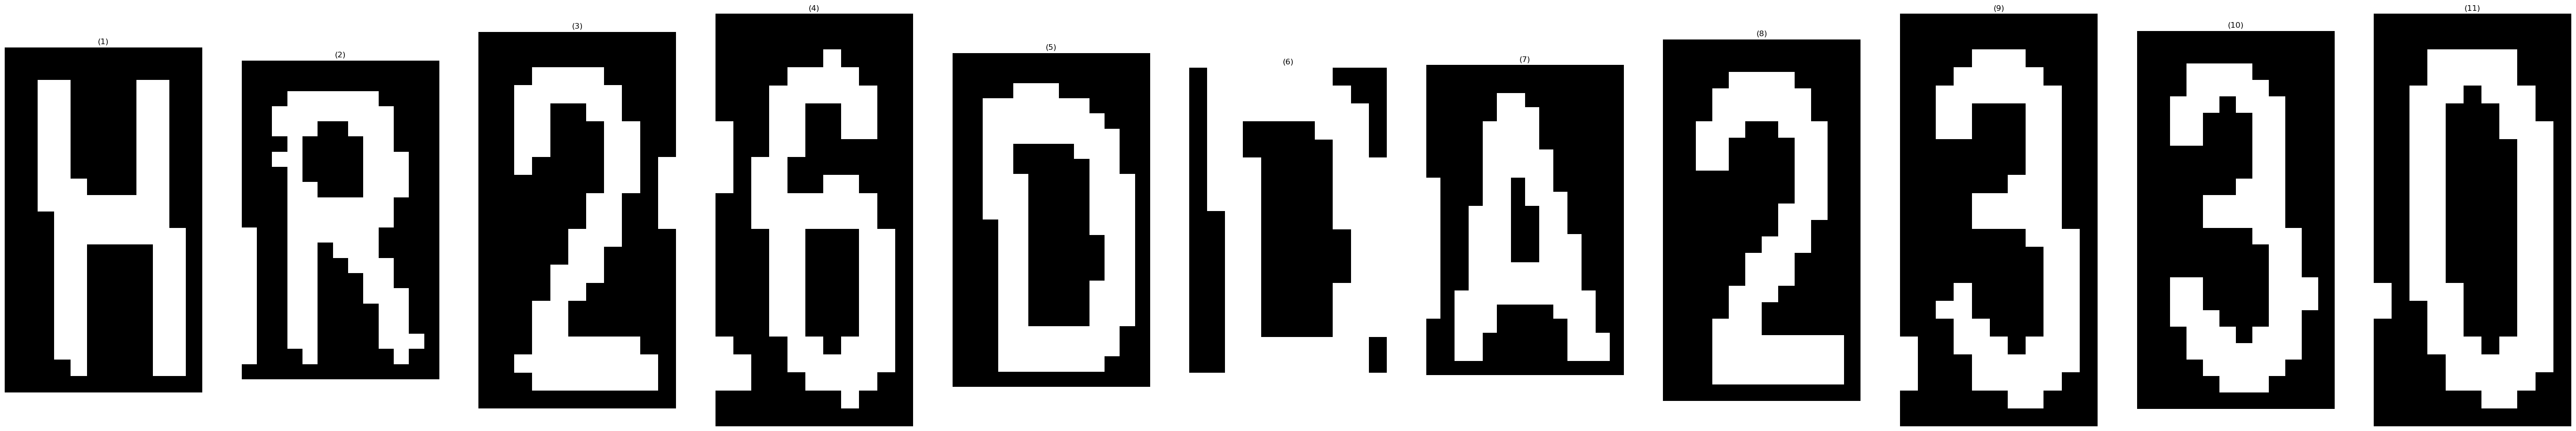

BR230BA233B
7.jpg


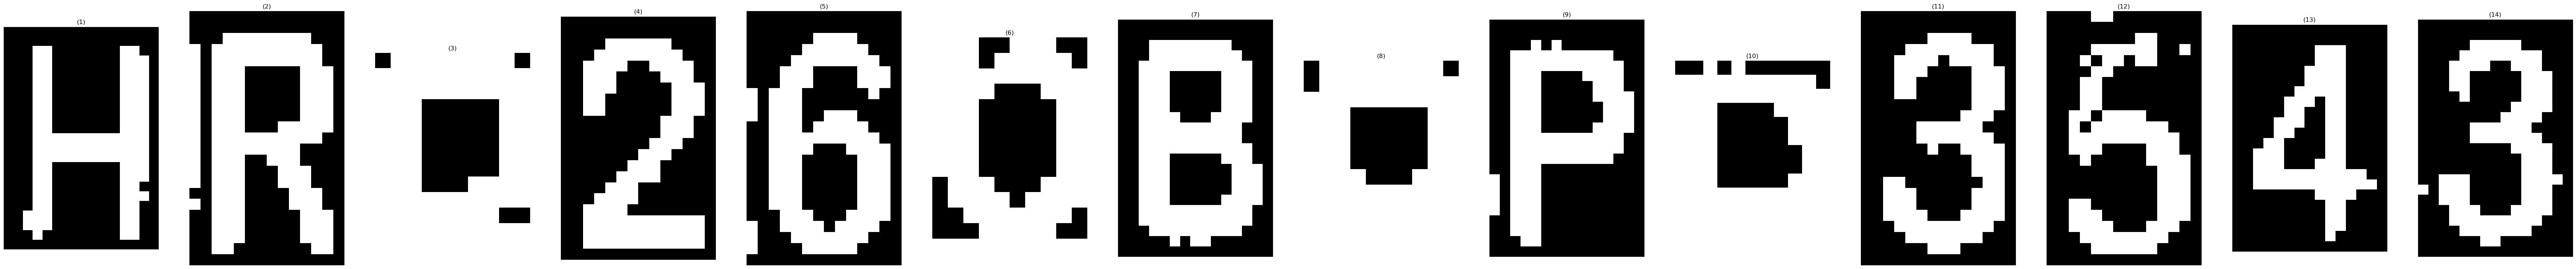

HRD2608DPD3643
8.jpg


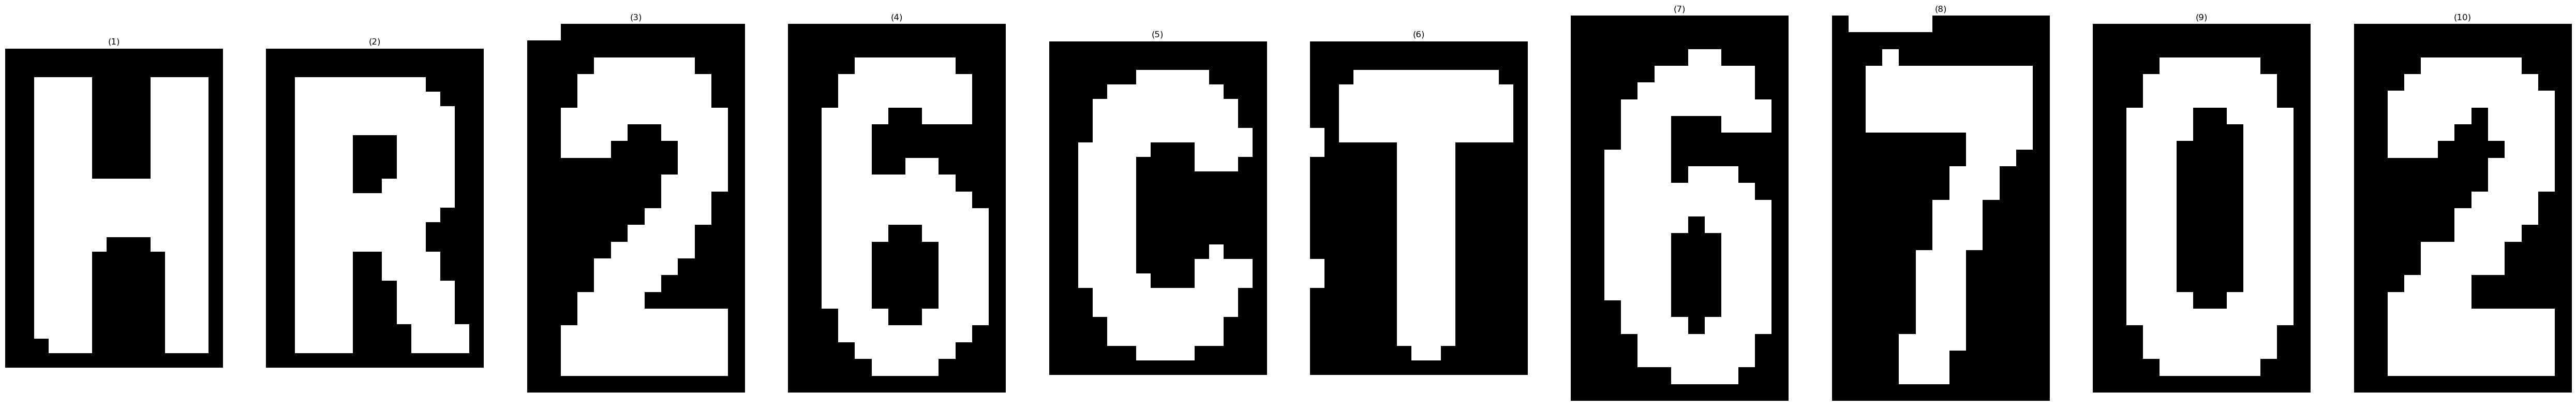

BR26CT6702
9.jpg


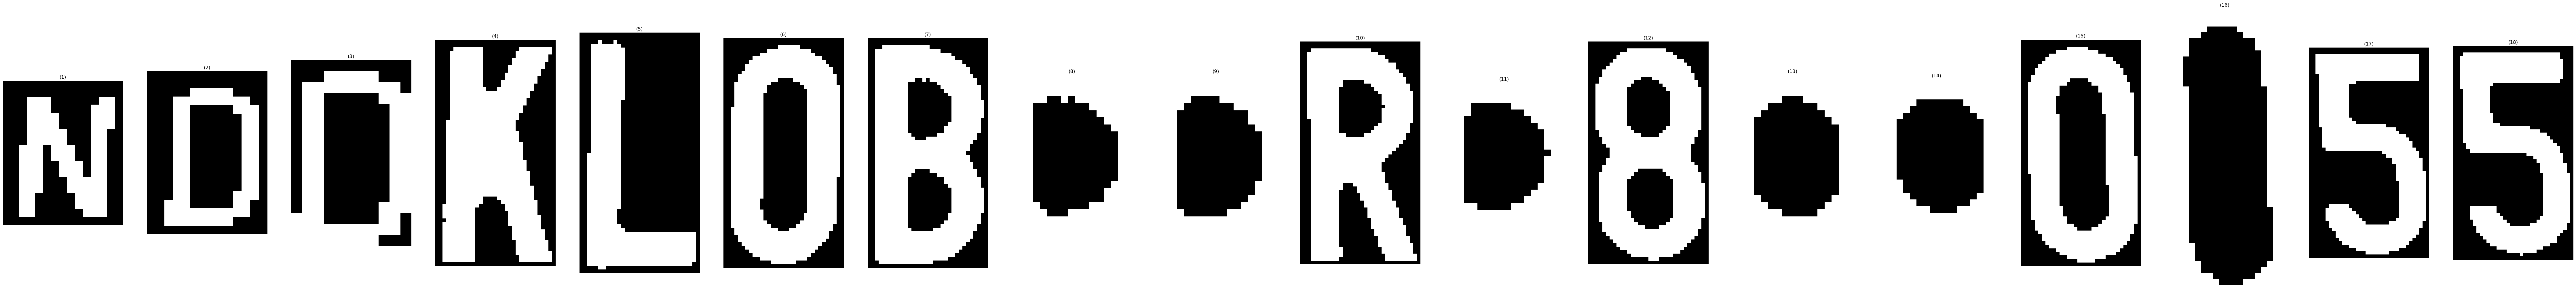

NB0KL08UDRU8DU0H55
12.jpg


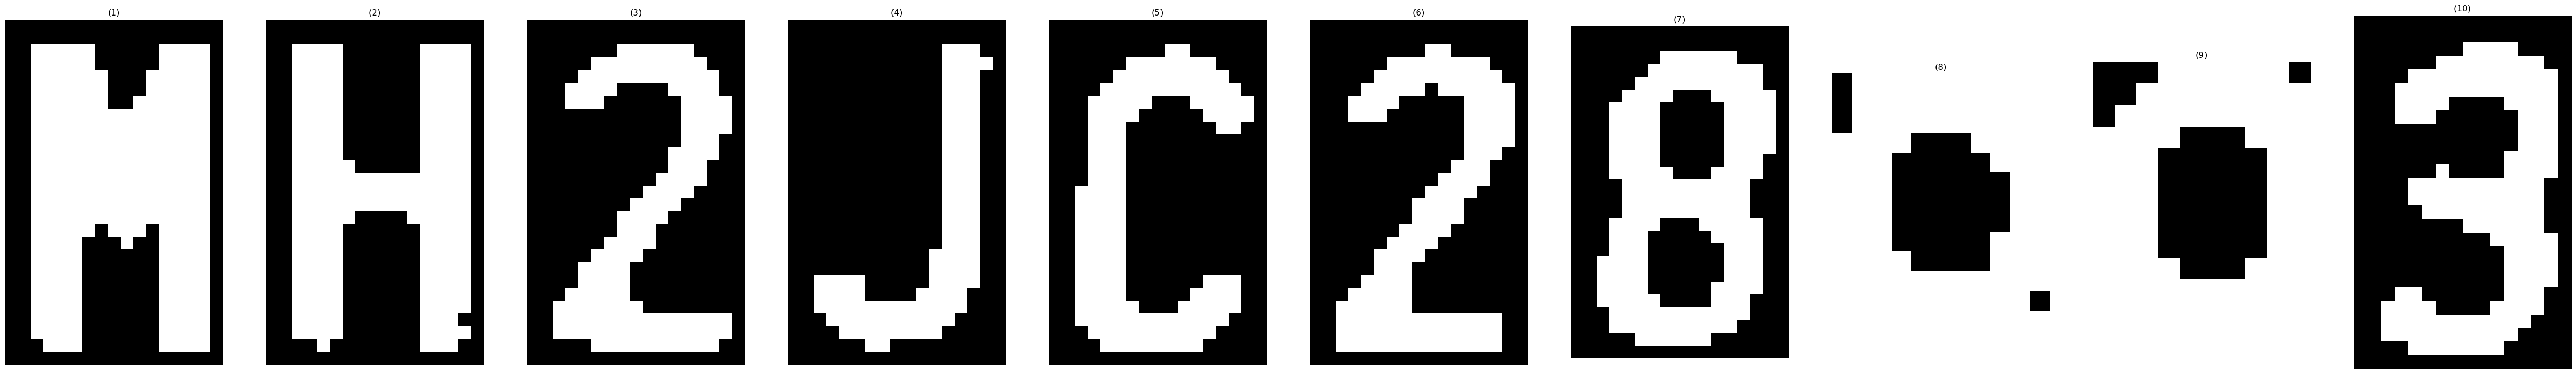

HH2JC28D03
13.jpg


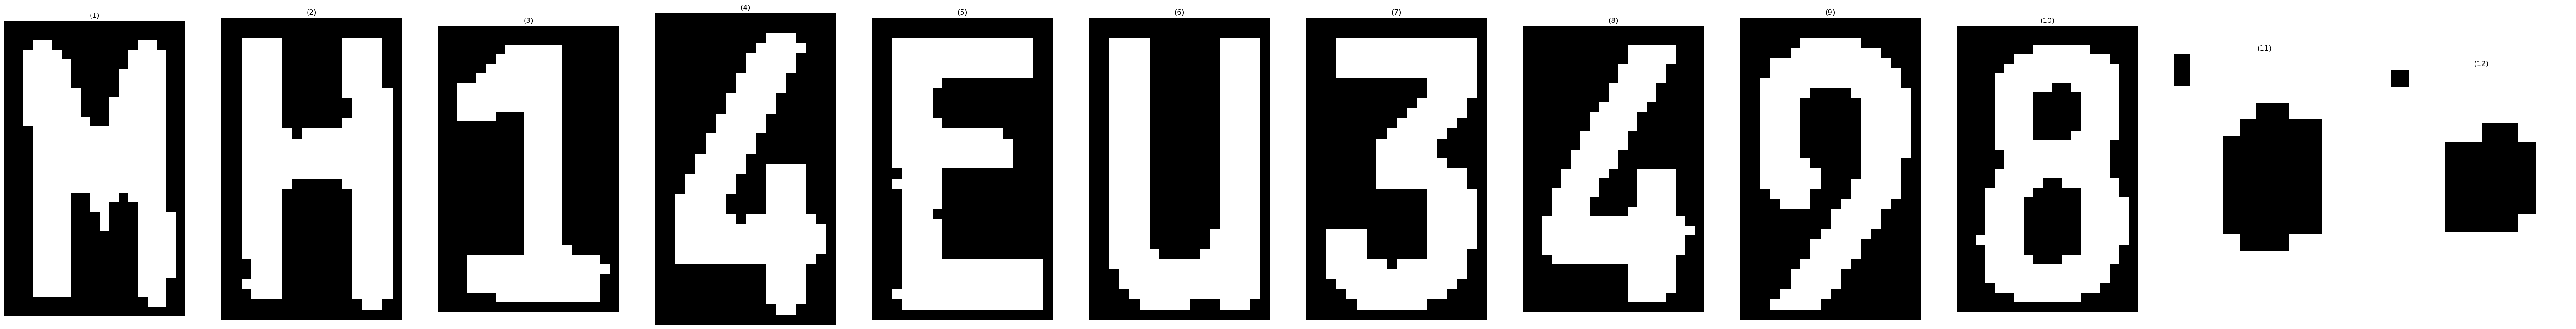

BH14EU3498DD
21.jpg


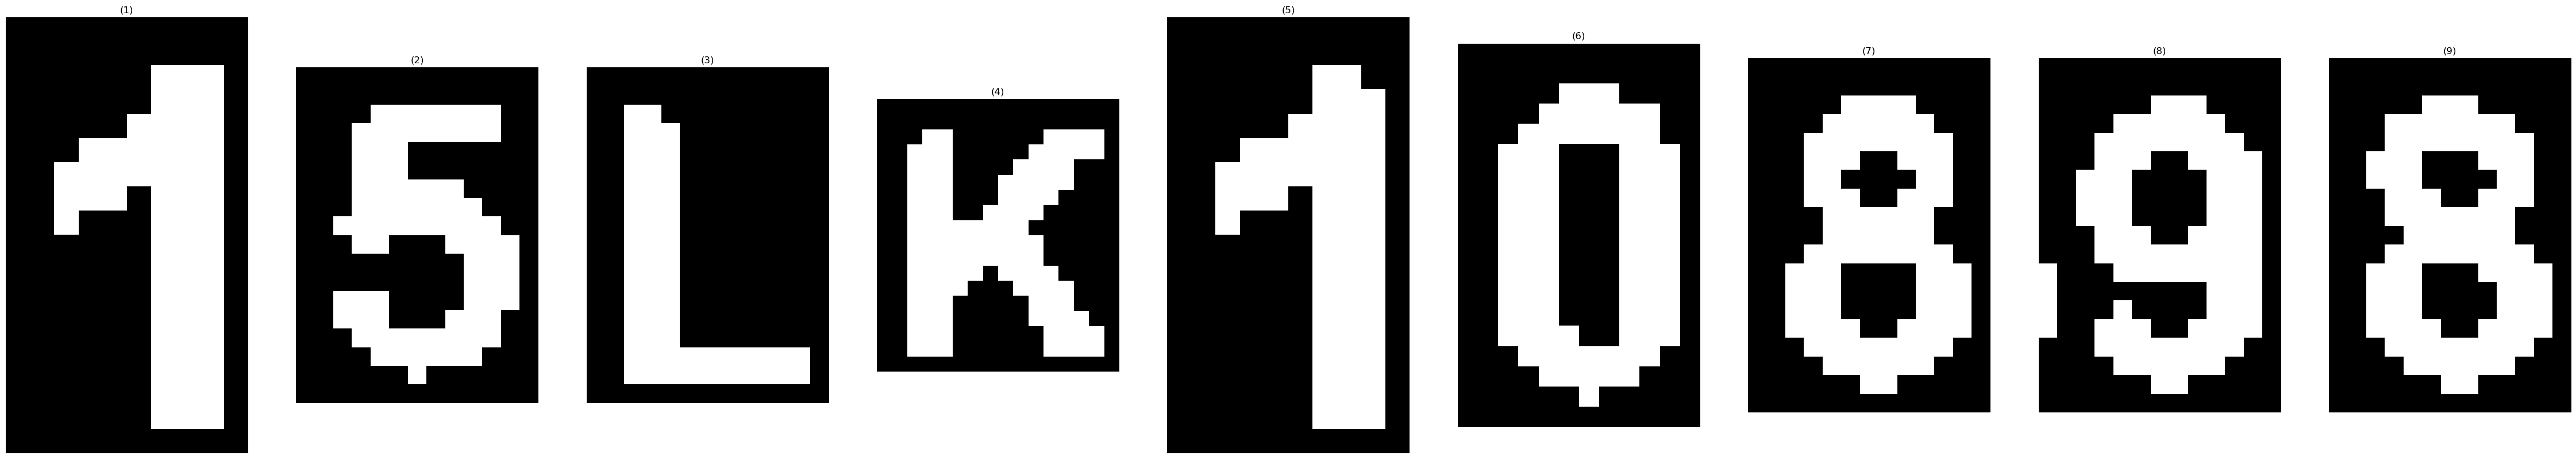

16LK10398
28.JPG


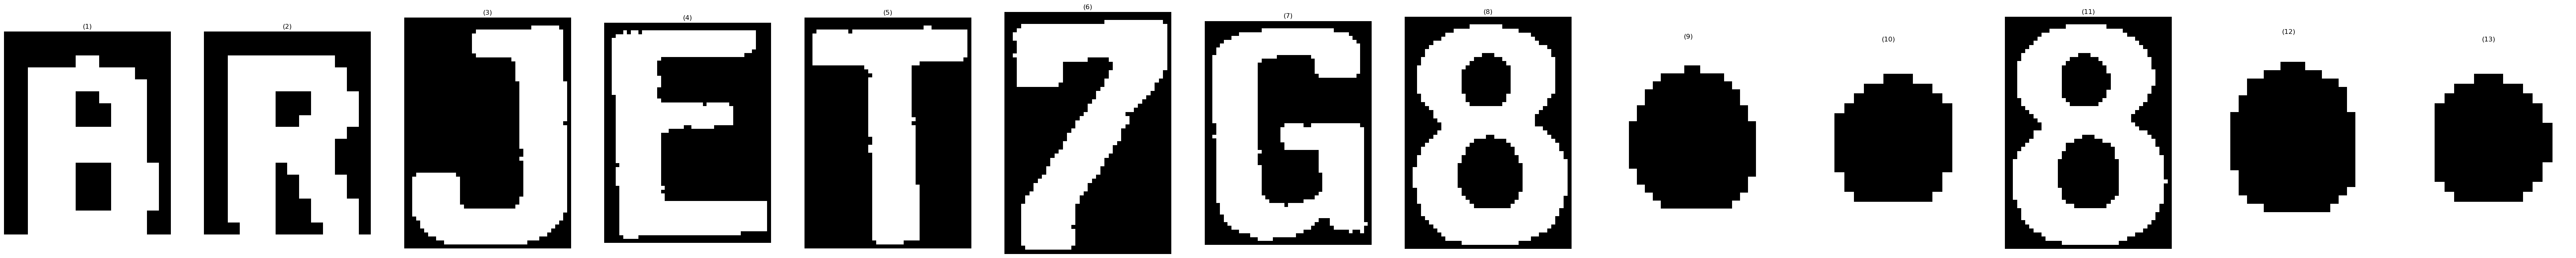

8RJLT768HD8HD
31.JPG


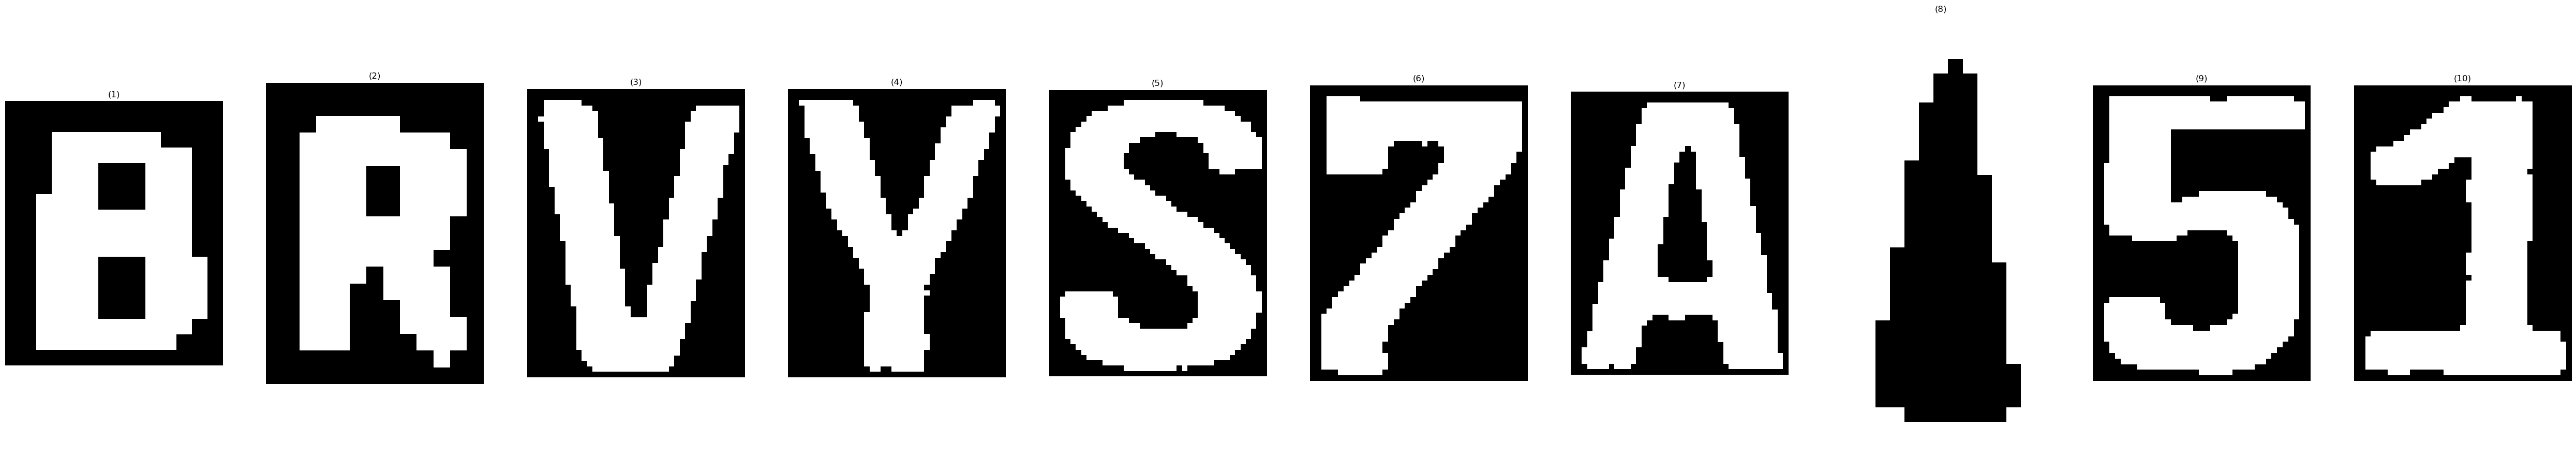

8RVYS7AH52
32.JPG


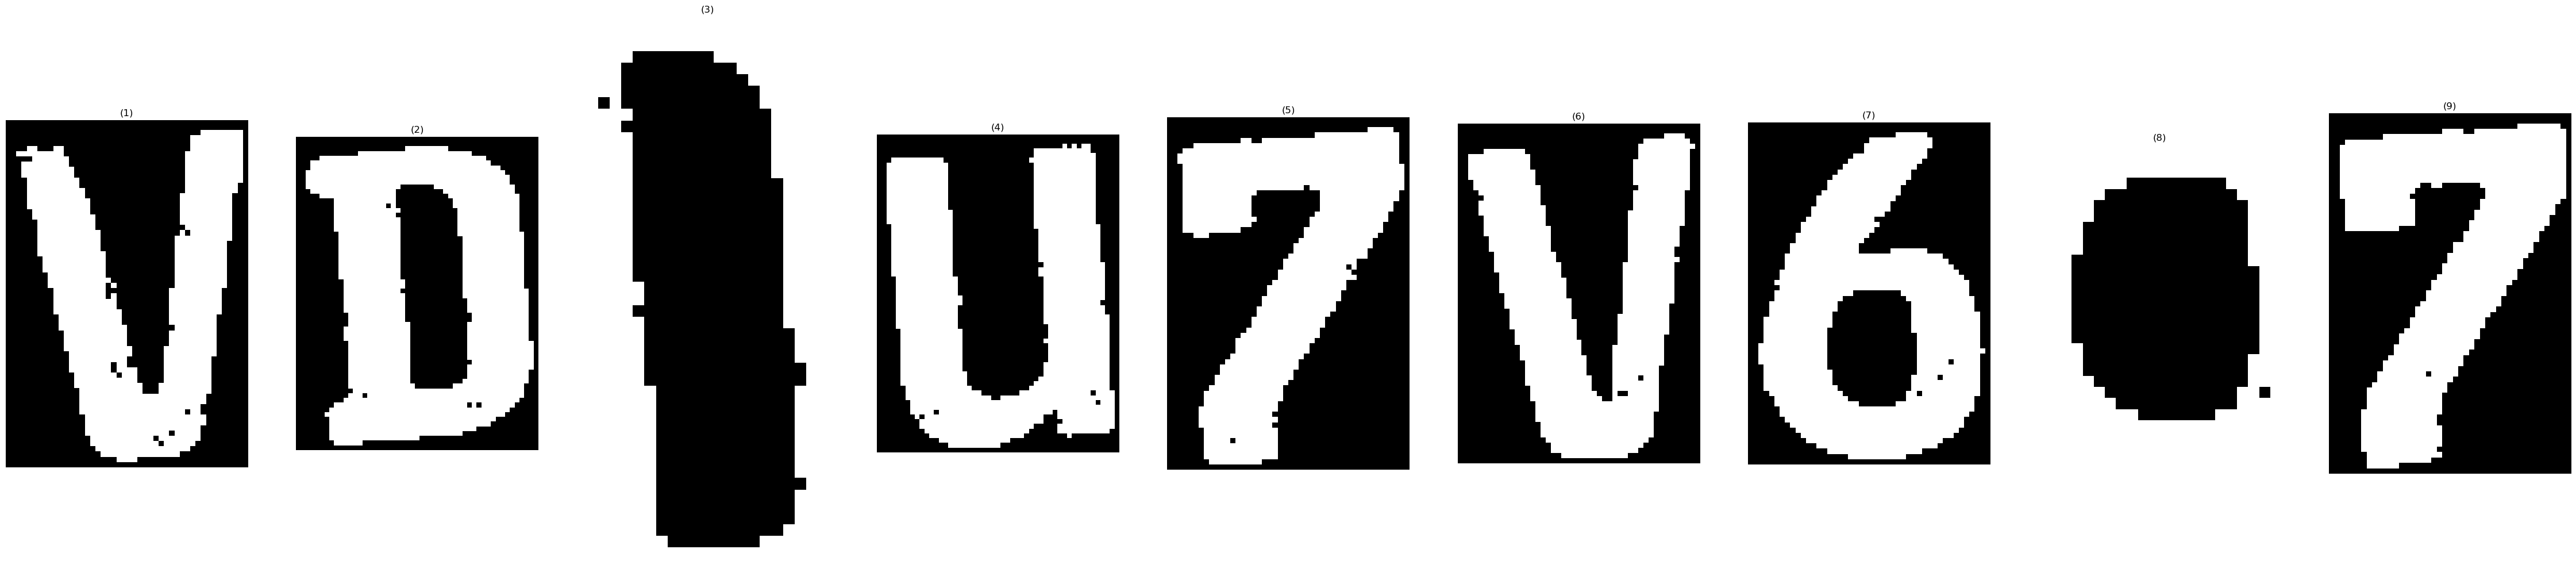

VBHU7V6H7
34.JPG


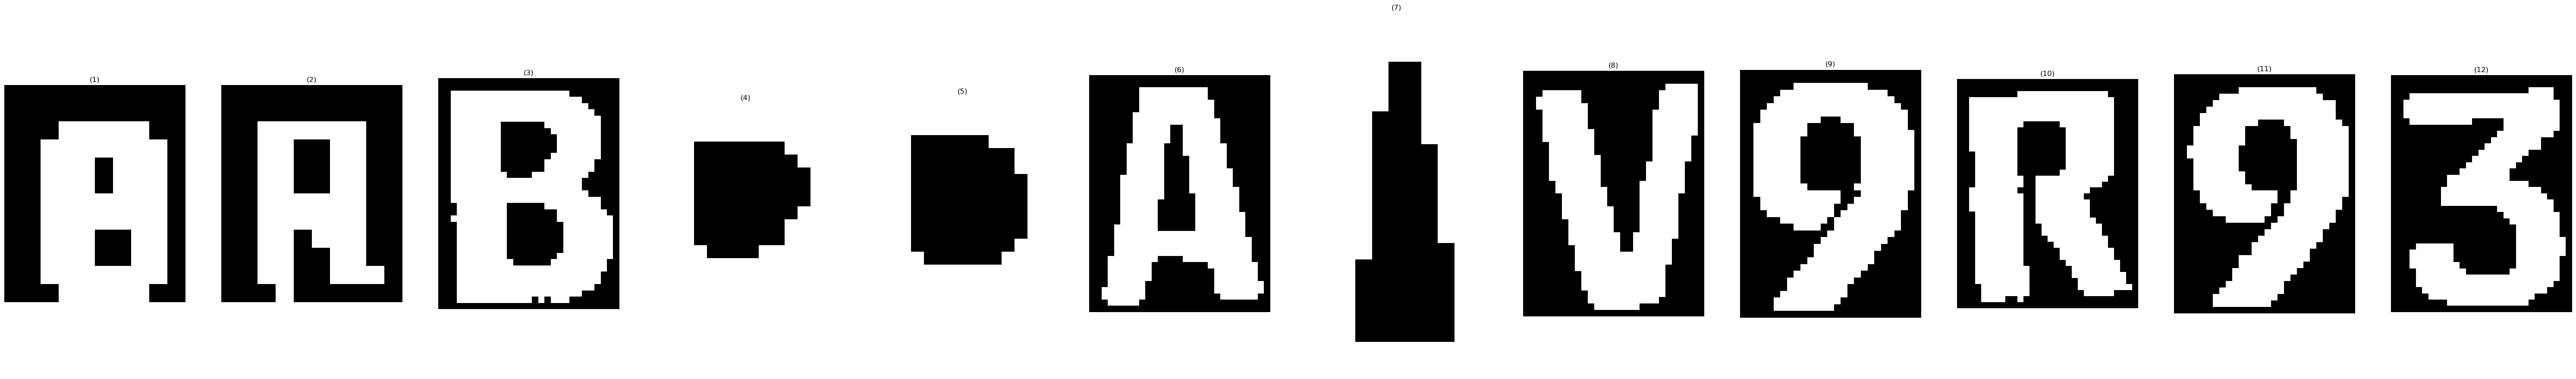

B4BDDAMV9R93
35.JPG


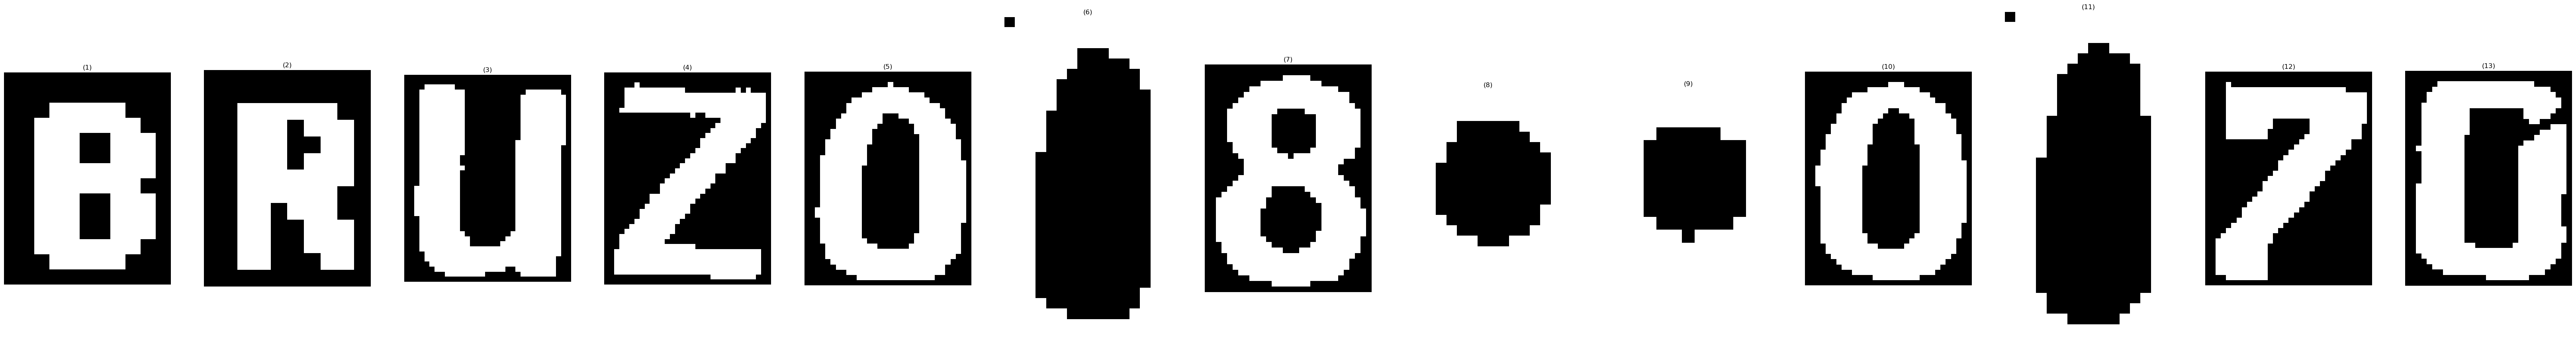

8RUZ0H8UD0H70
36.JPG


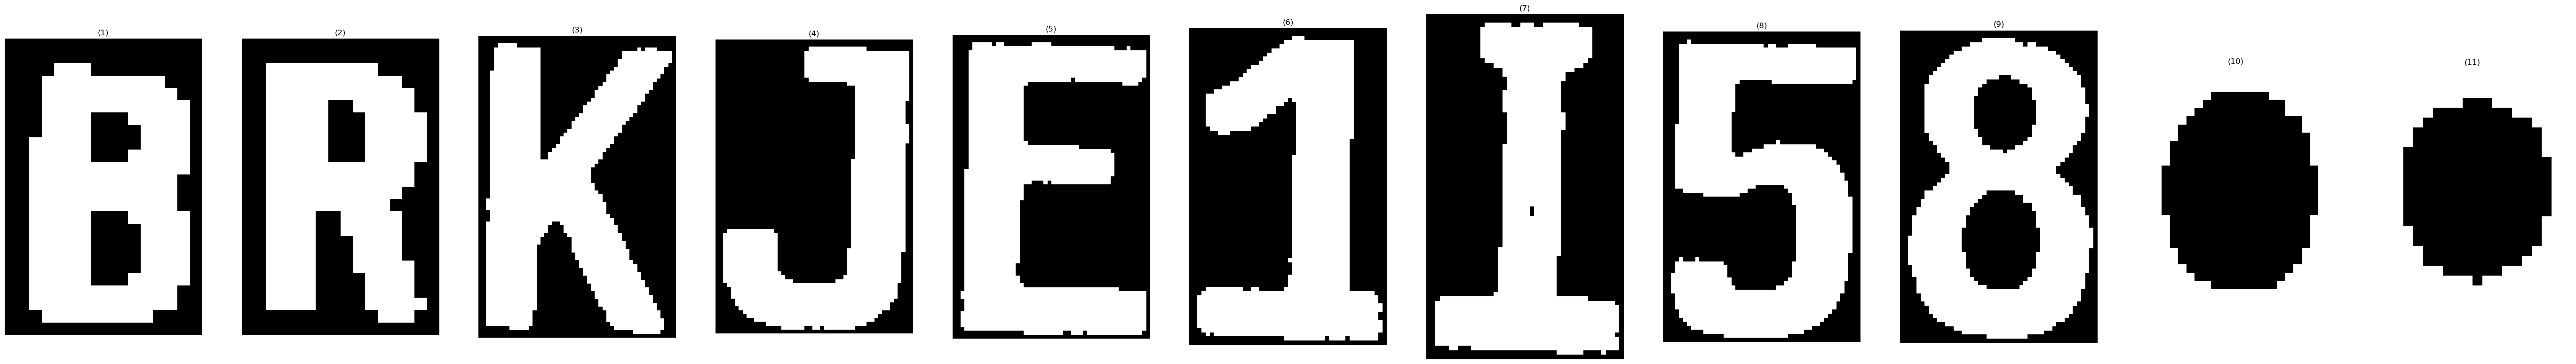

8RKJE2I58HU
39.JPG


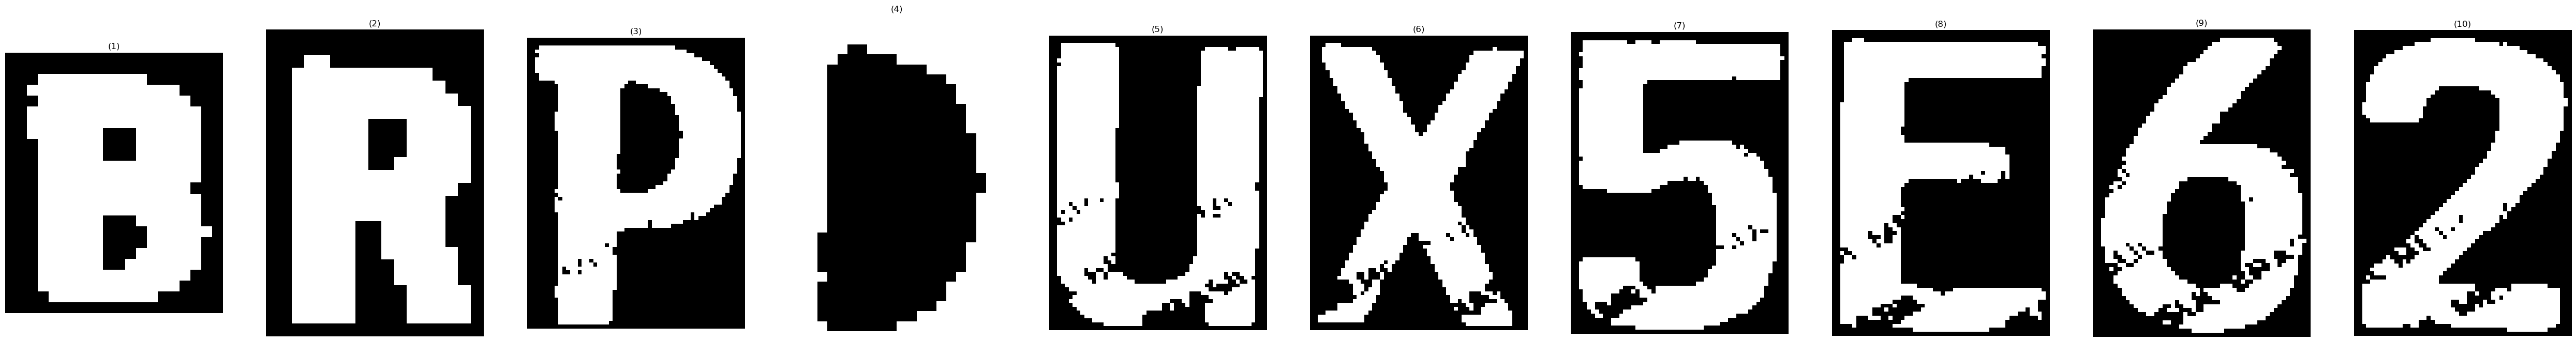

8RPHUX5E62
42.JPG


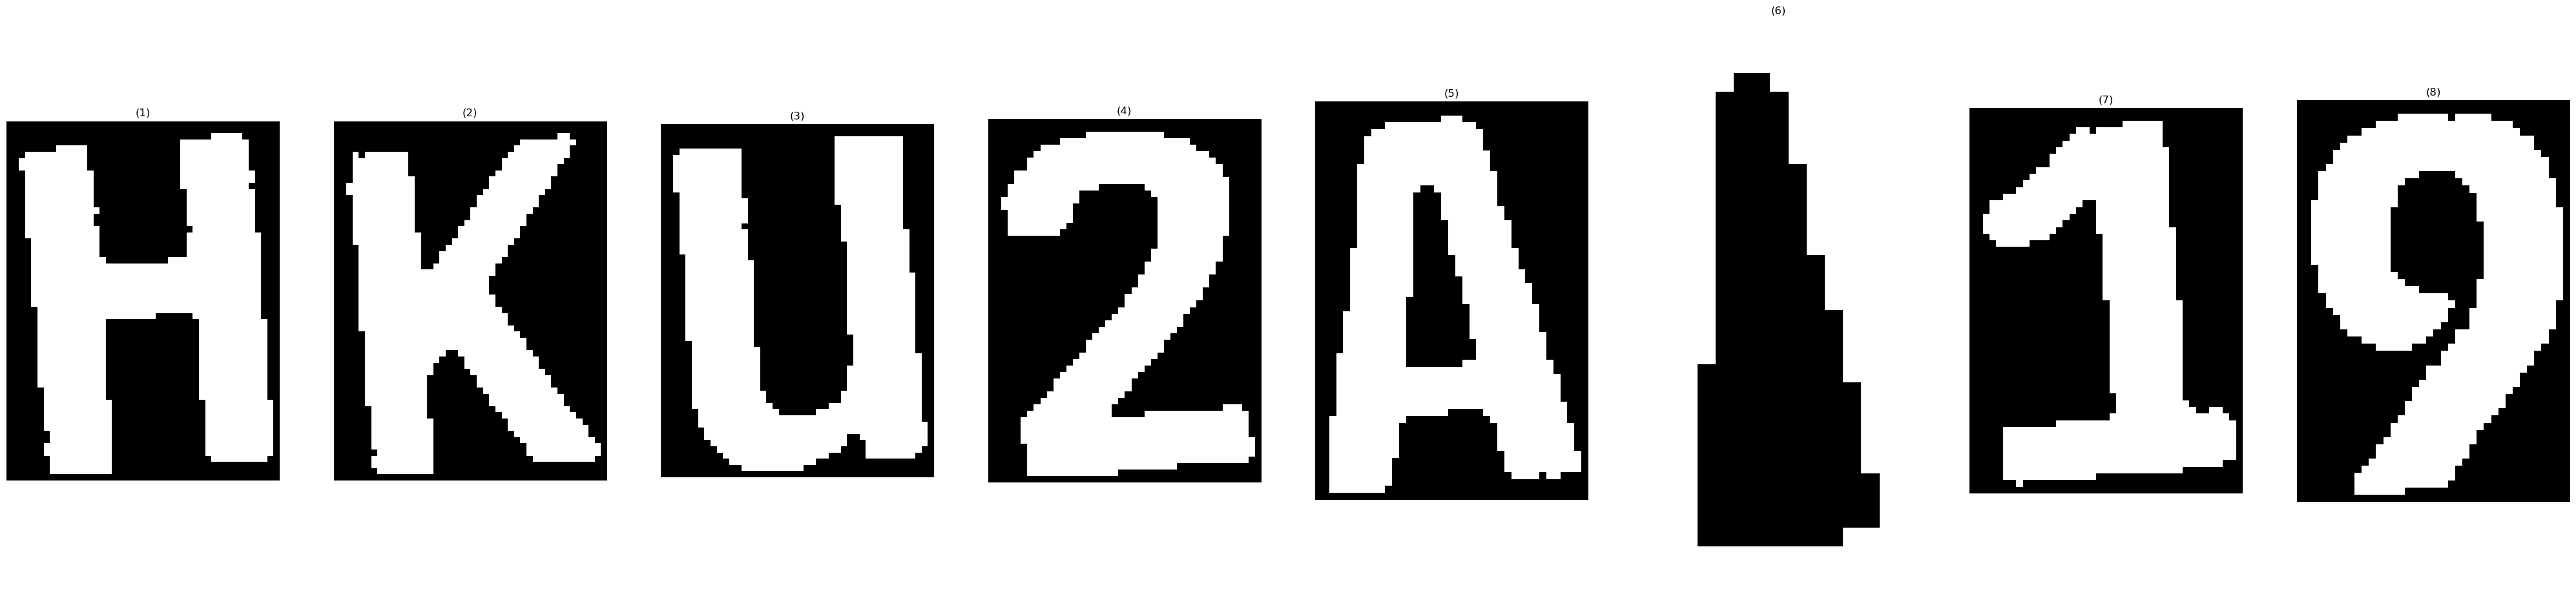

HKU2AH19
44.JPG


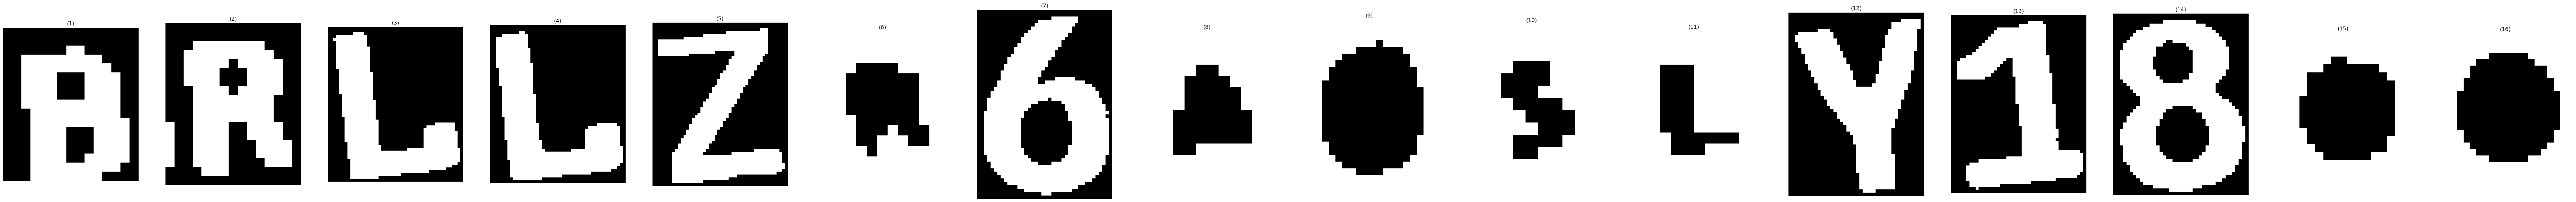

88LLZD6DDDBY18DD
47.JPG


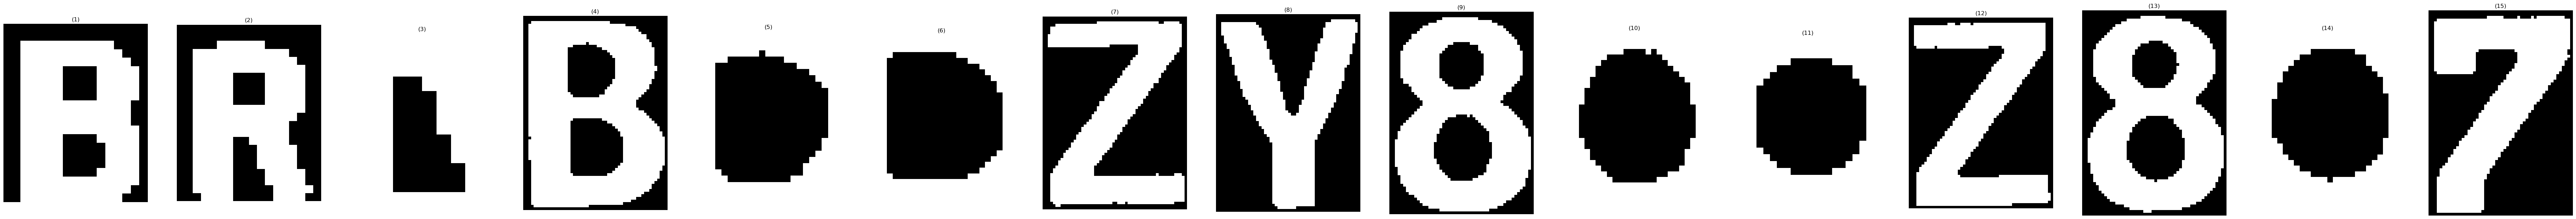

8RDBHHZY8HDZ8U7
54.JPG


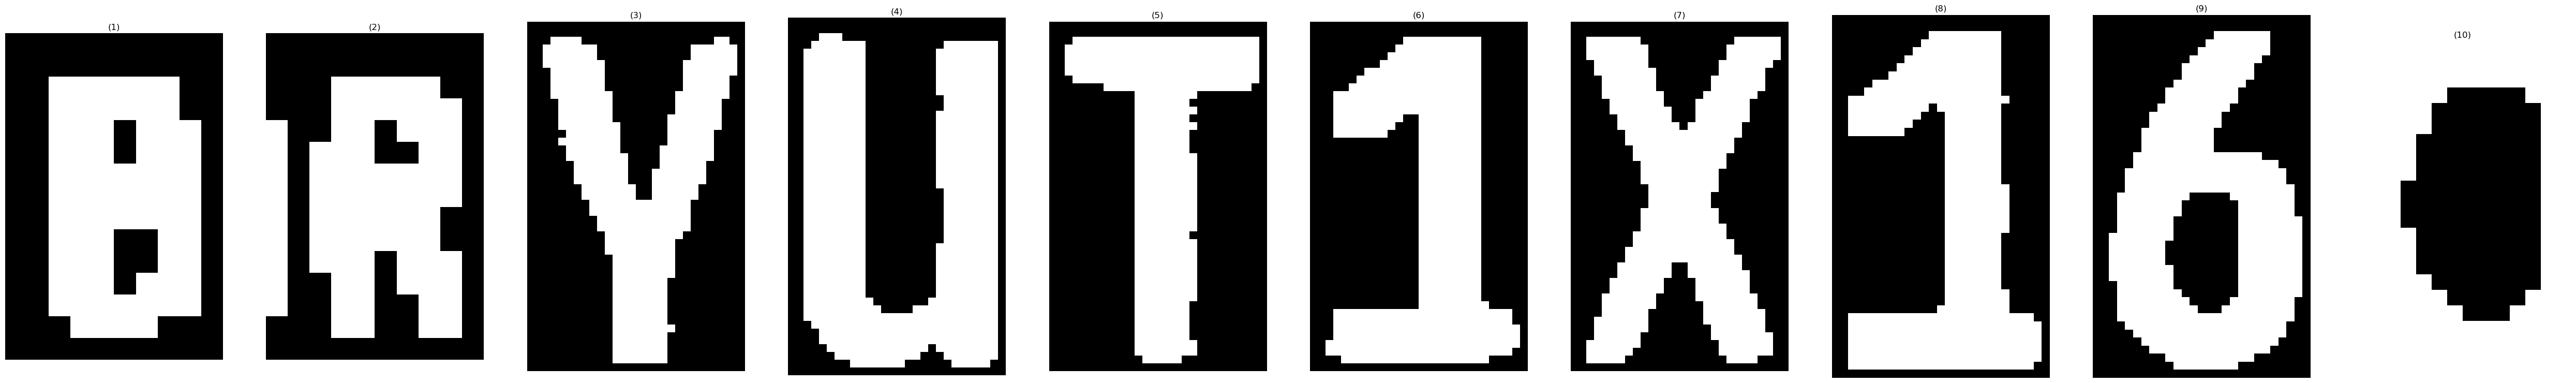

84YHT1X16U
55.JPG


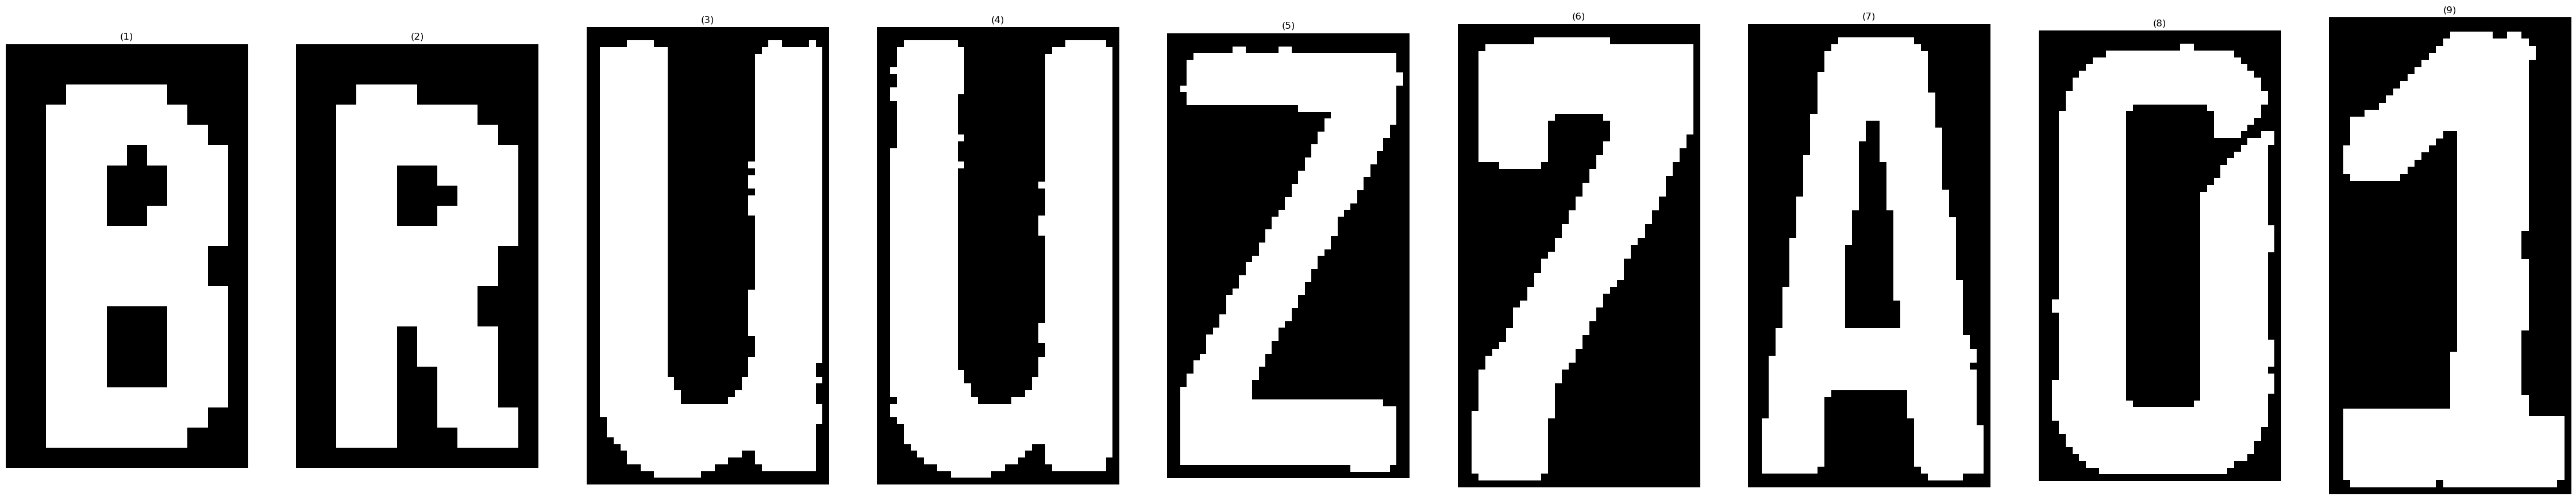

8RUUZ7A02
56.JPG


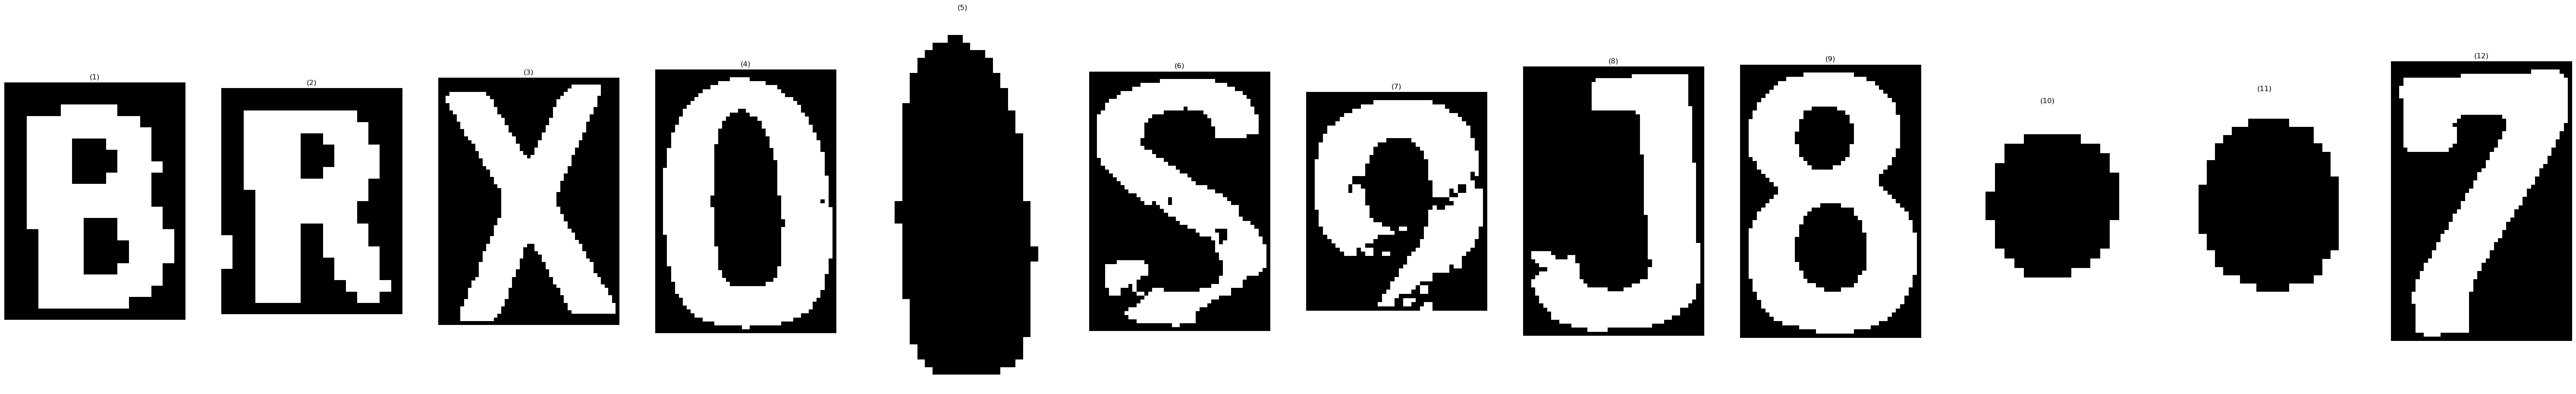

8RX0HS0J8UH7
57.JPG


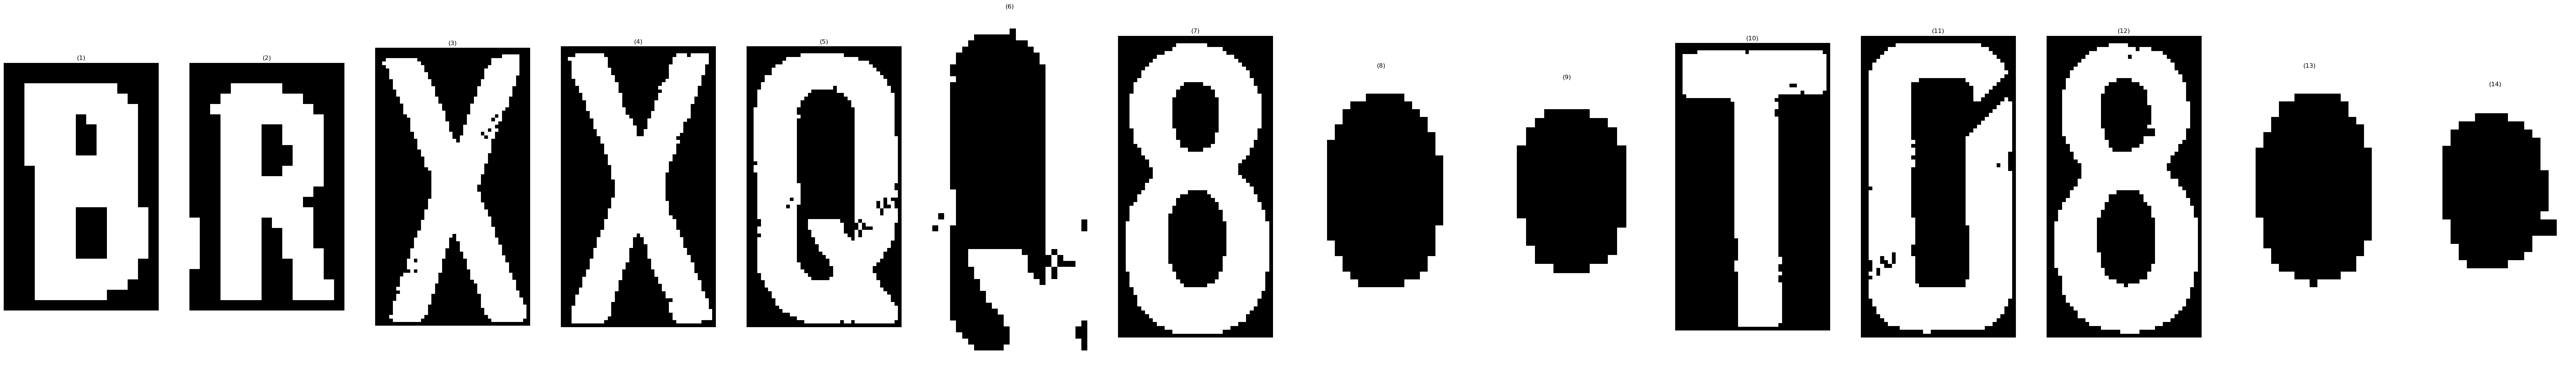

8BXX0U8HUTU8HD
58.JPG


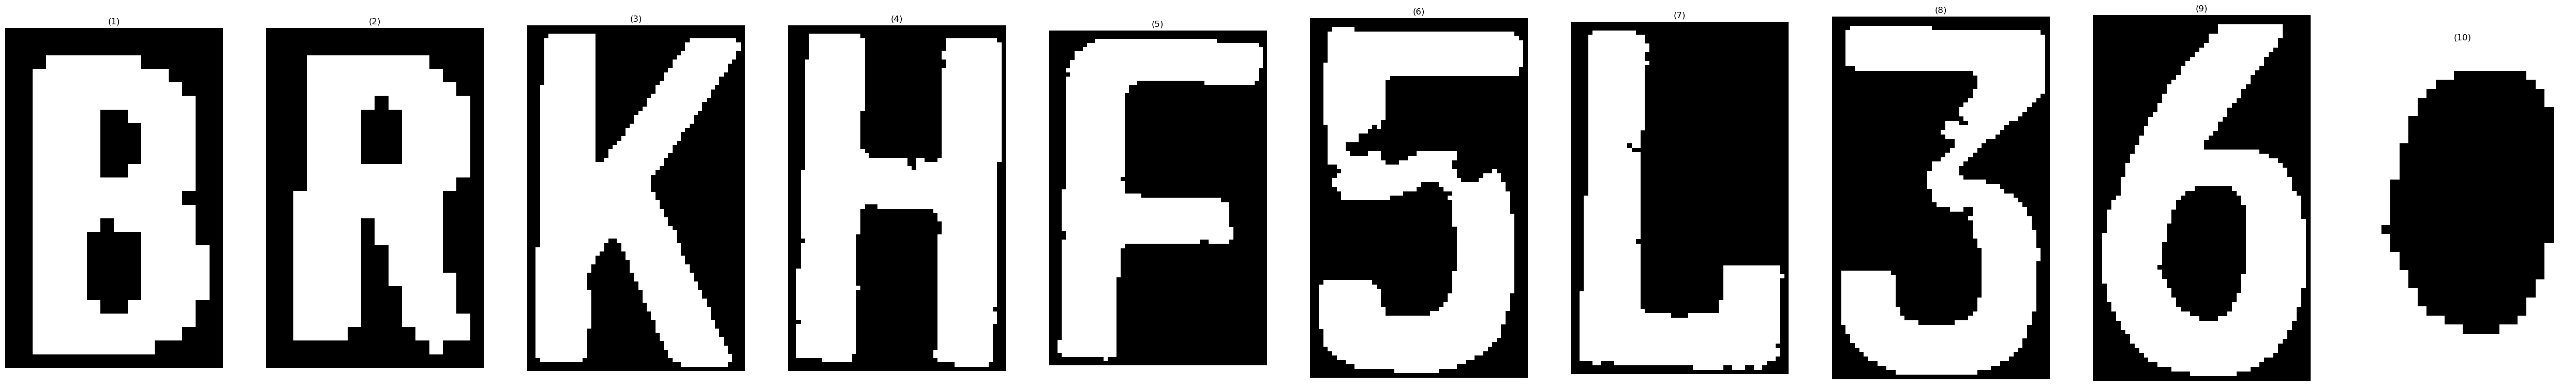

88KHF5L36L
61.JPG


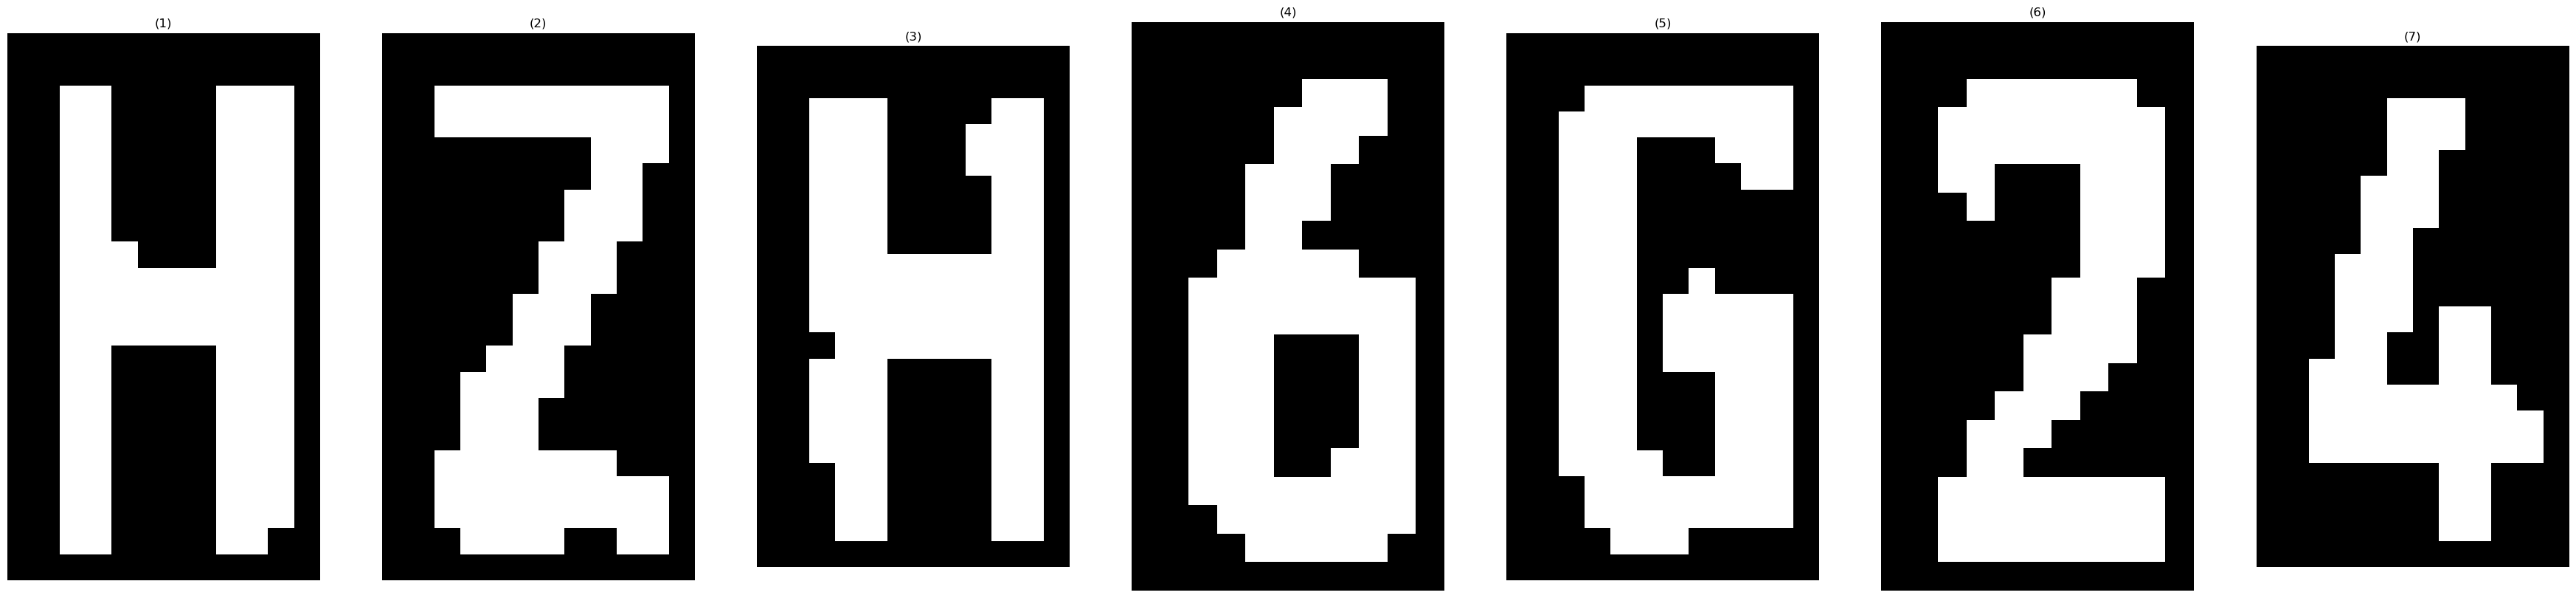

HZB6B2A
68.JPG


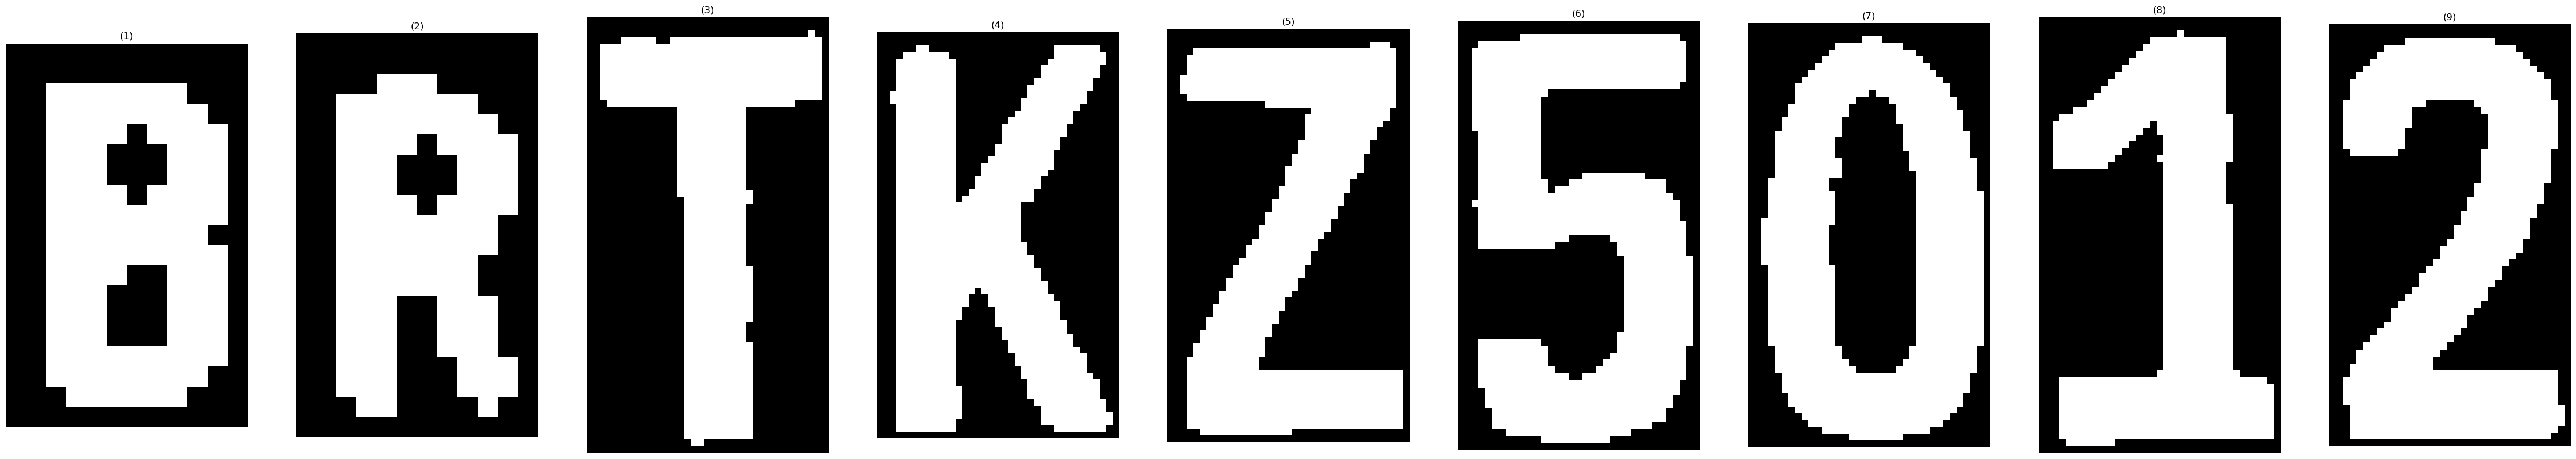

8BTKZ5012
69.JPG


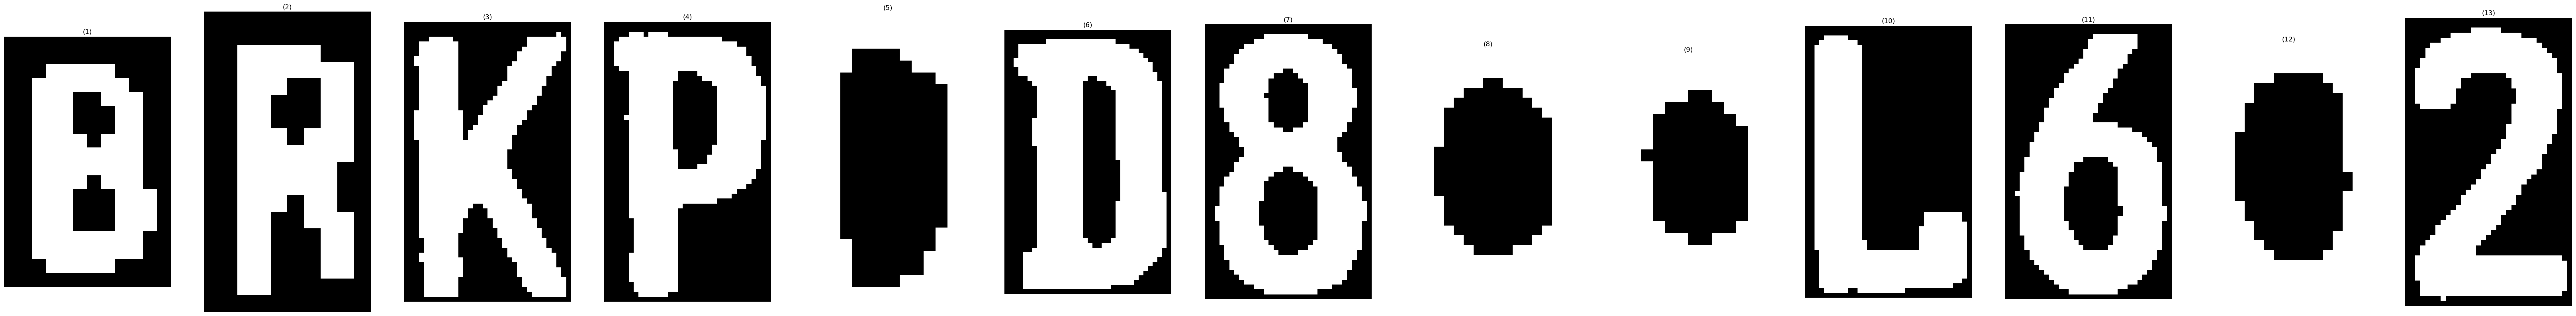

8BKPUB8UCL6U2
72.jpg


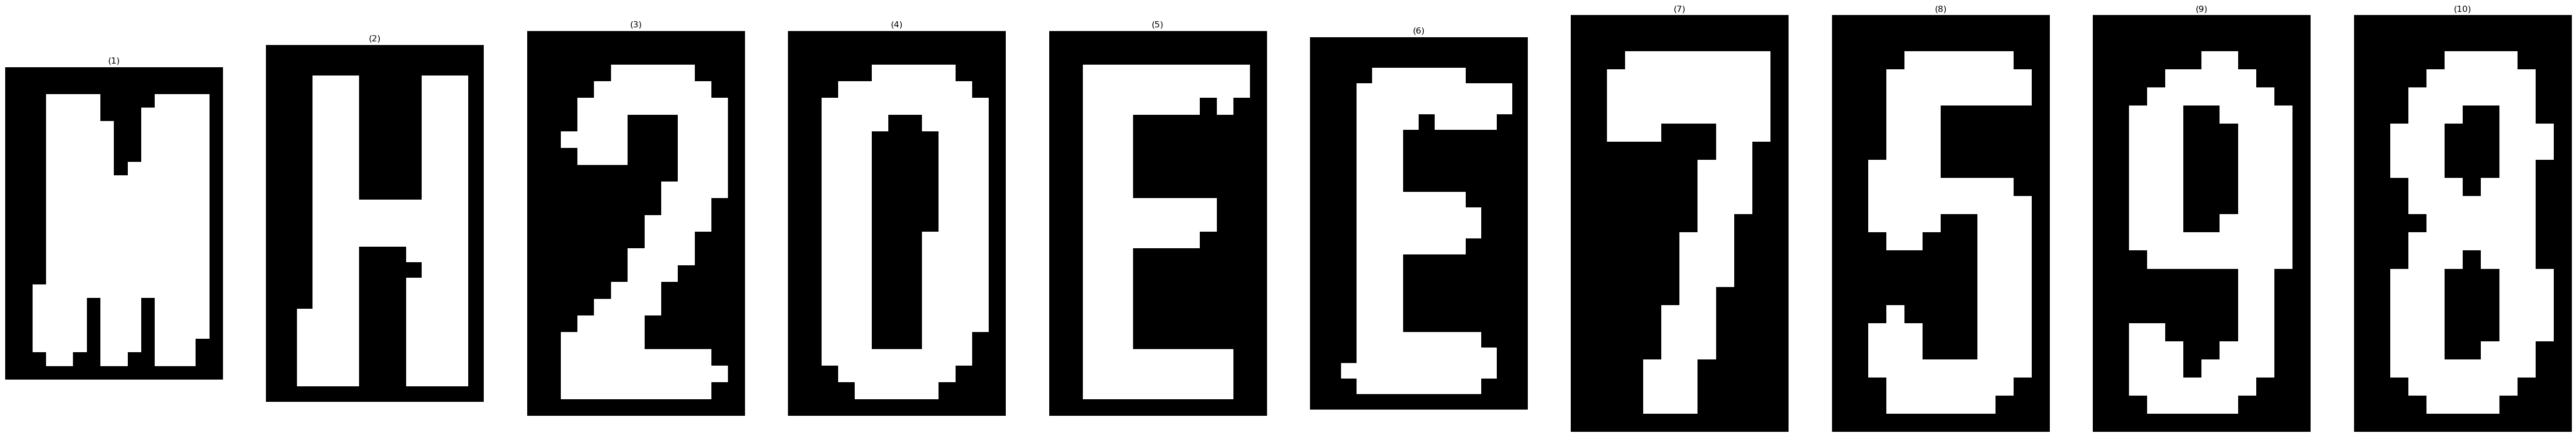

8B20EF7598
73.jpg


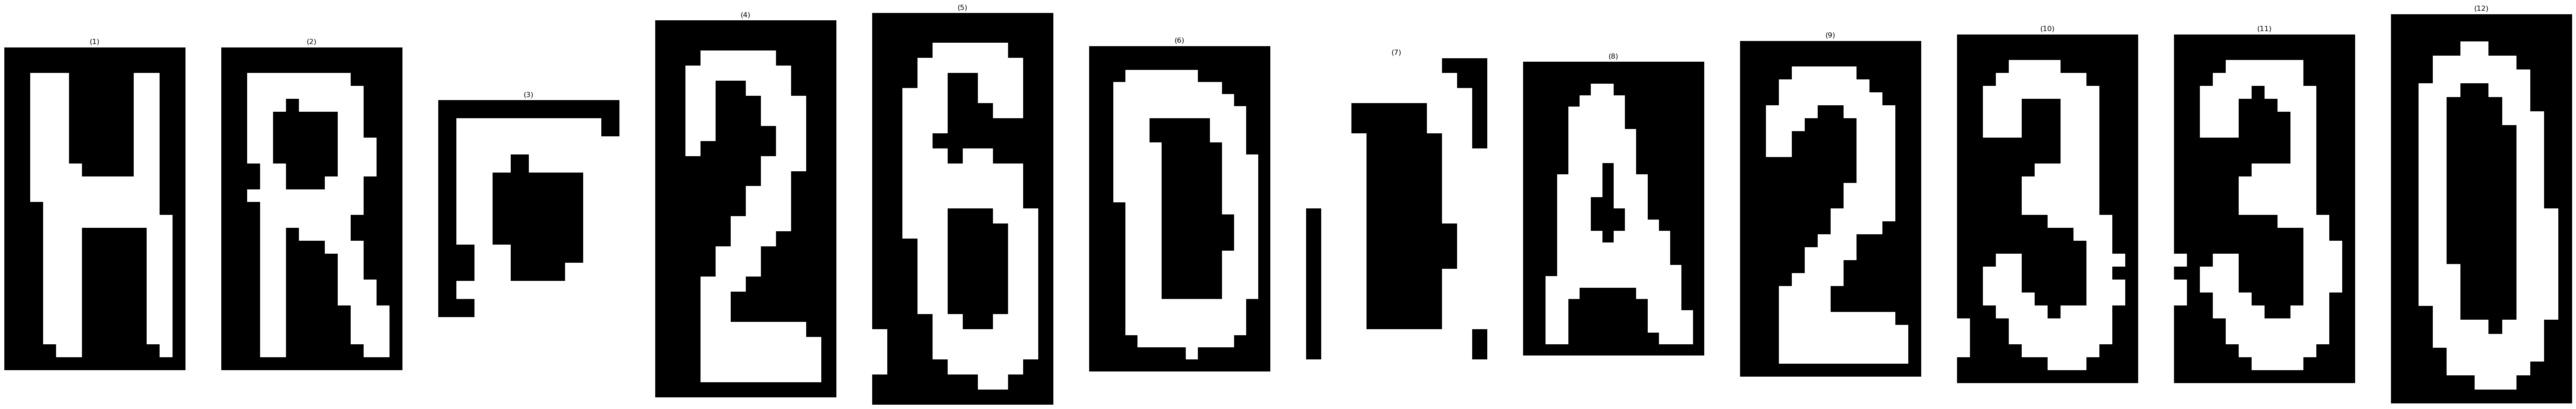

BR02BBDA2330
74.jpg


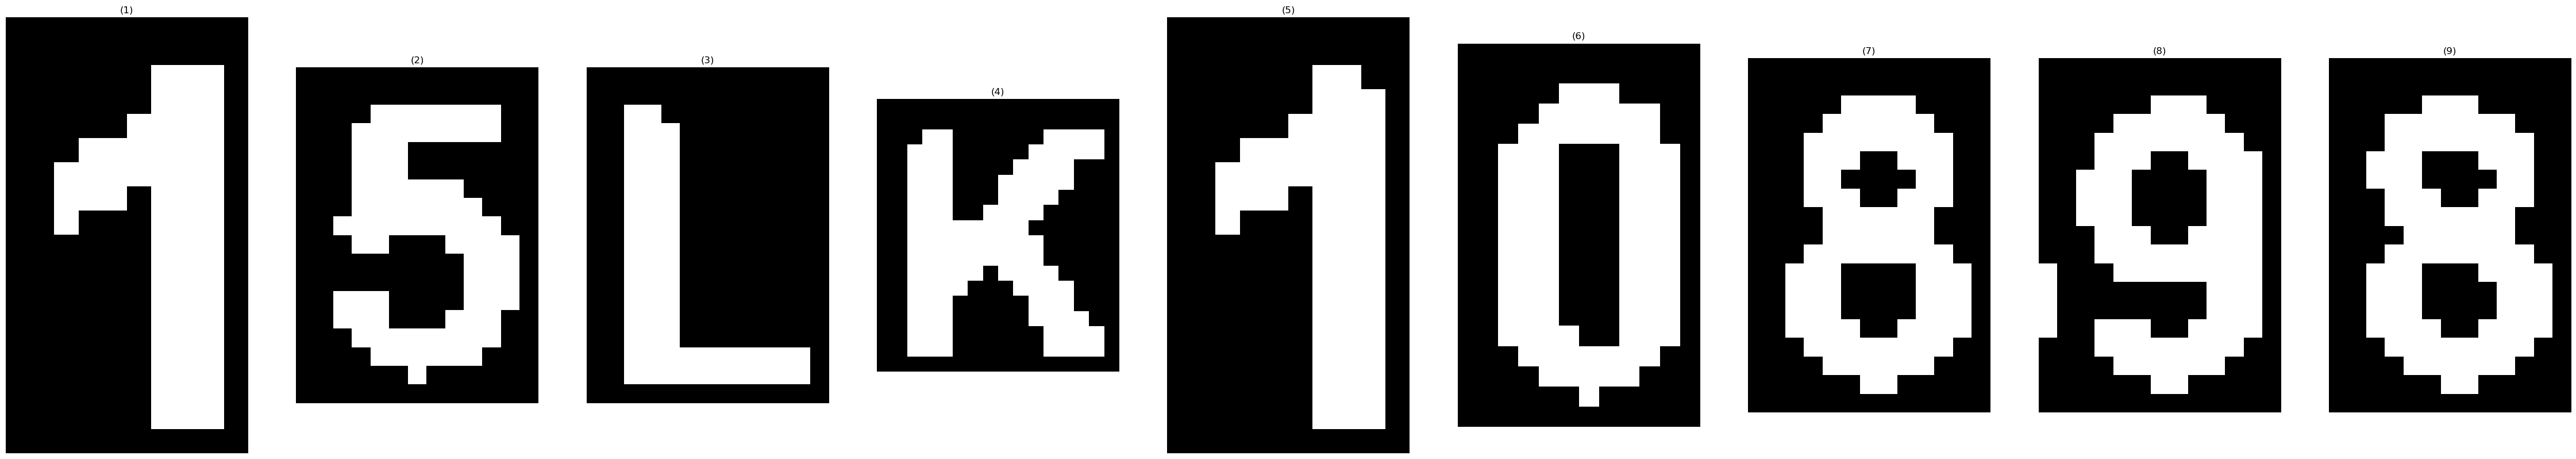

16LK10398
75.jpg


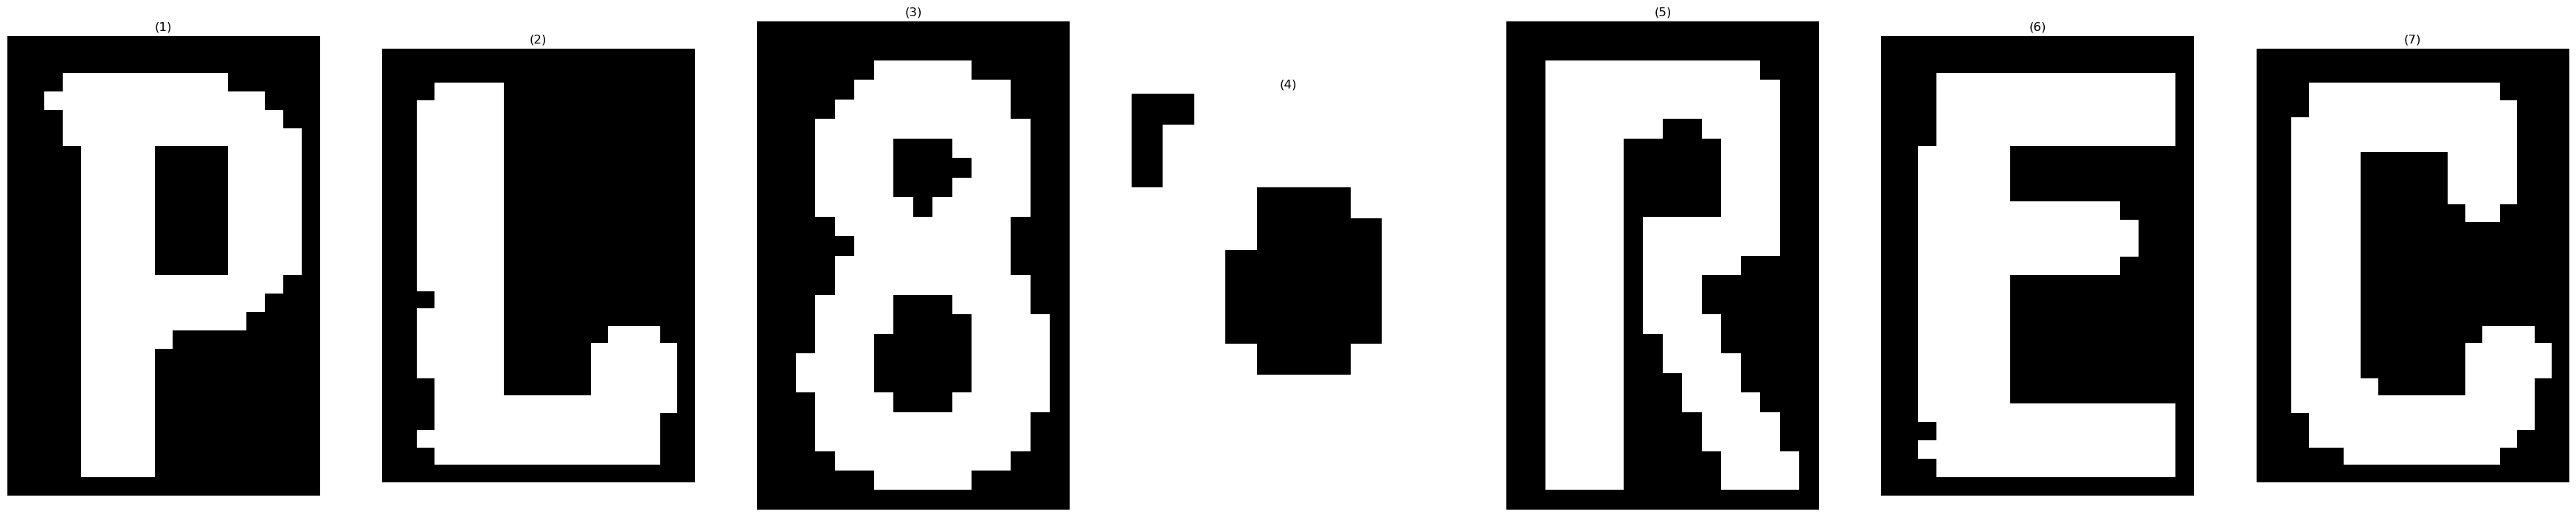

PL80RE0
76.JPG


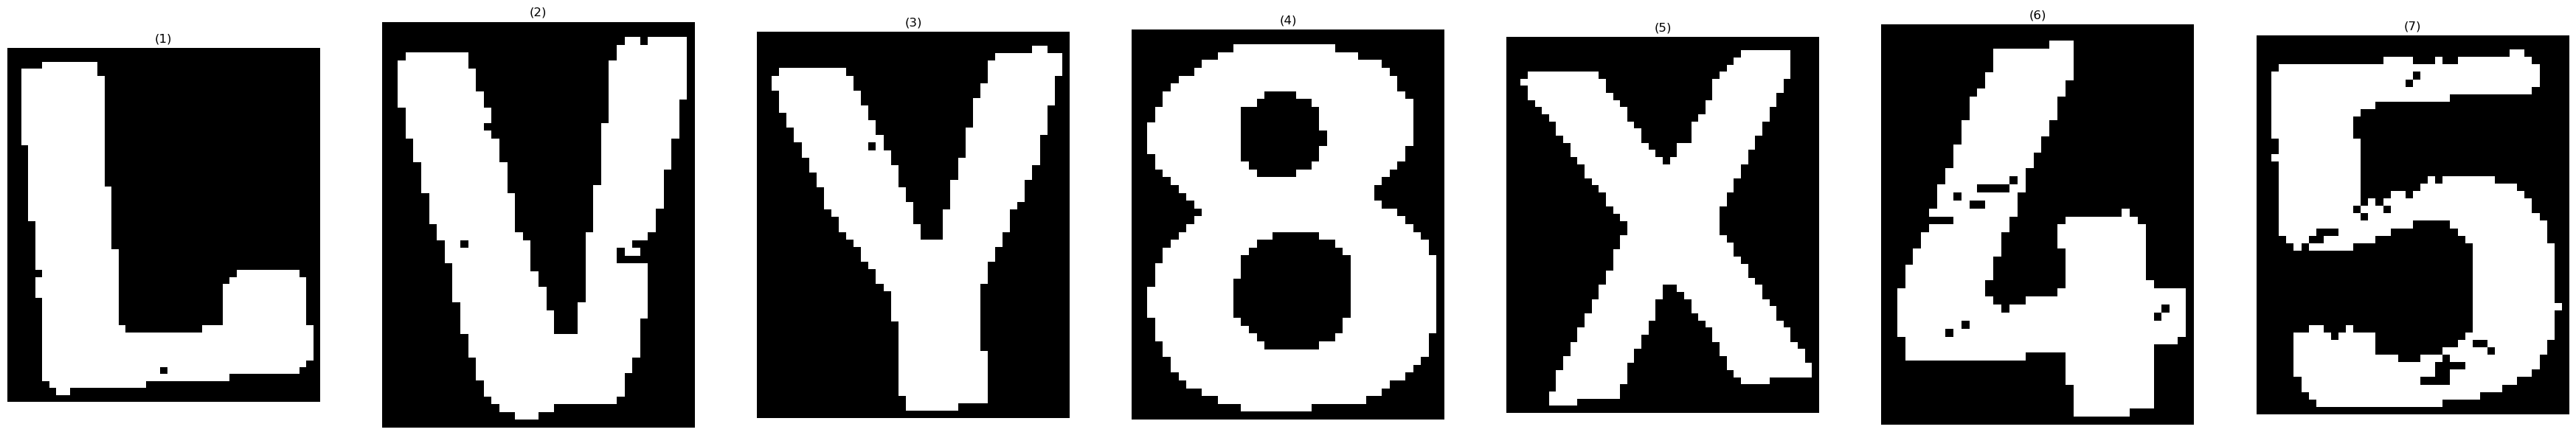

LVV8XA5
80.jpg


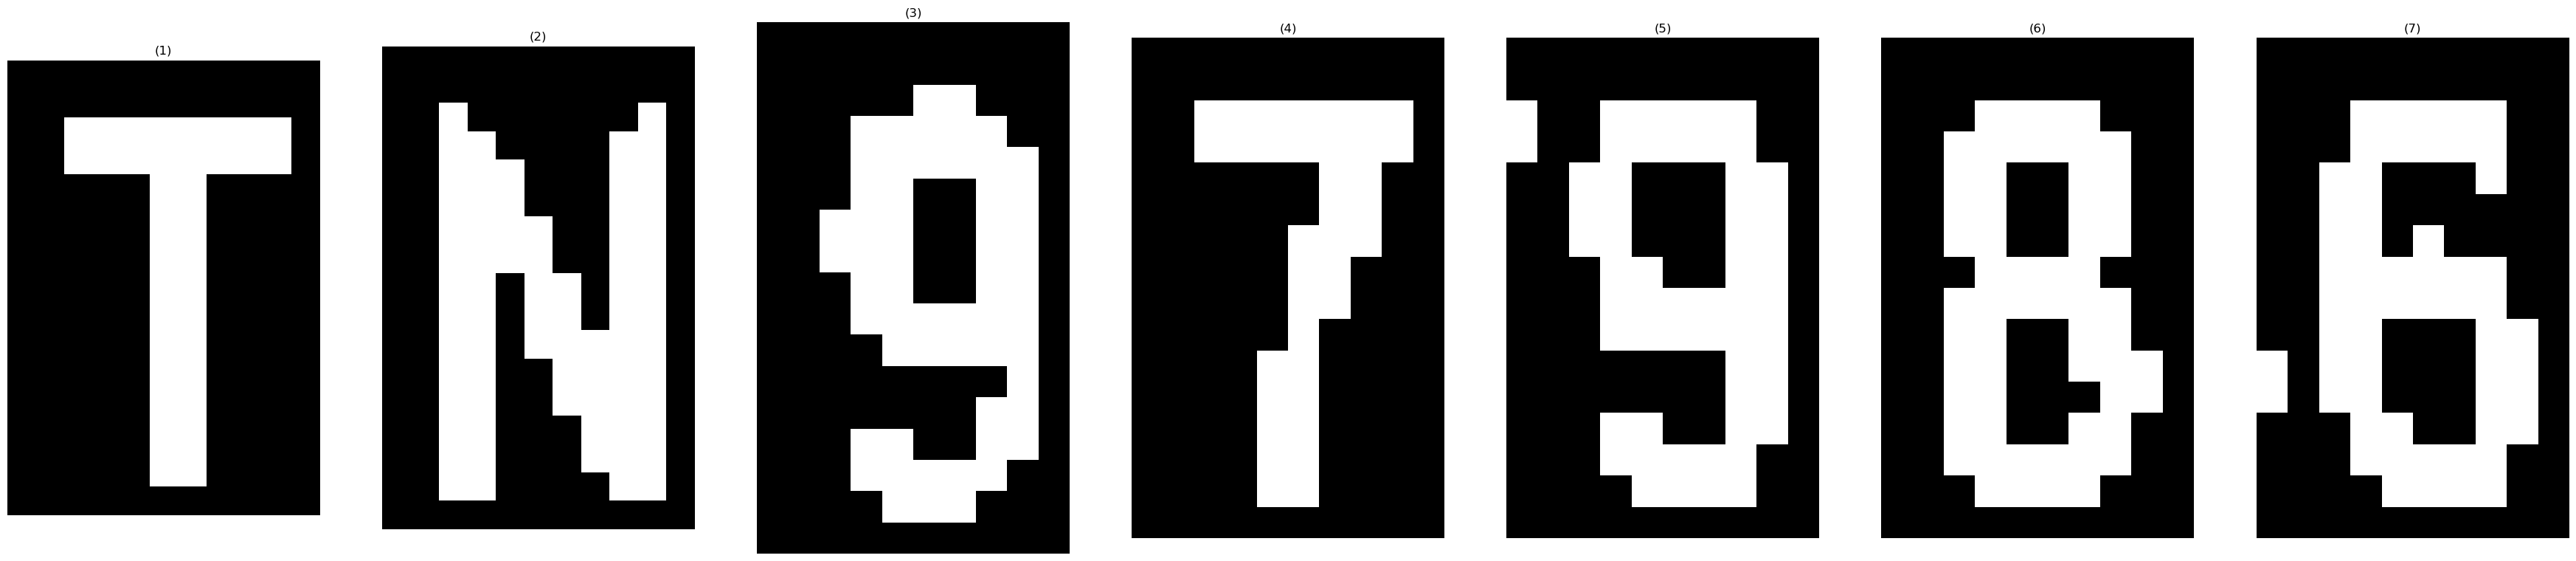

TN37386
81.jpg


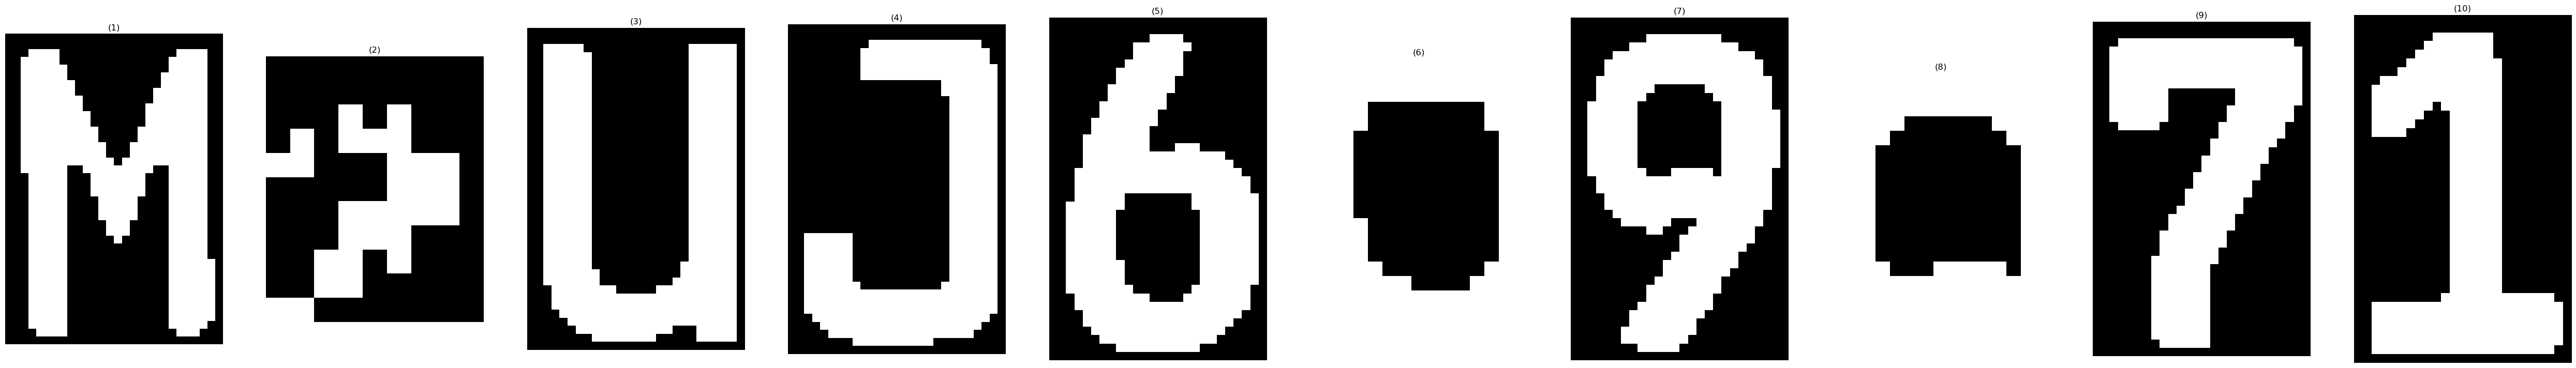

M1UJ6U9D71
82.jpg


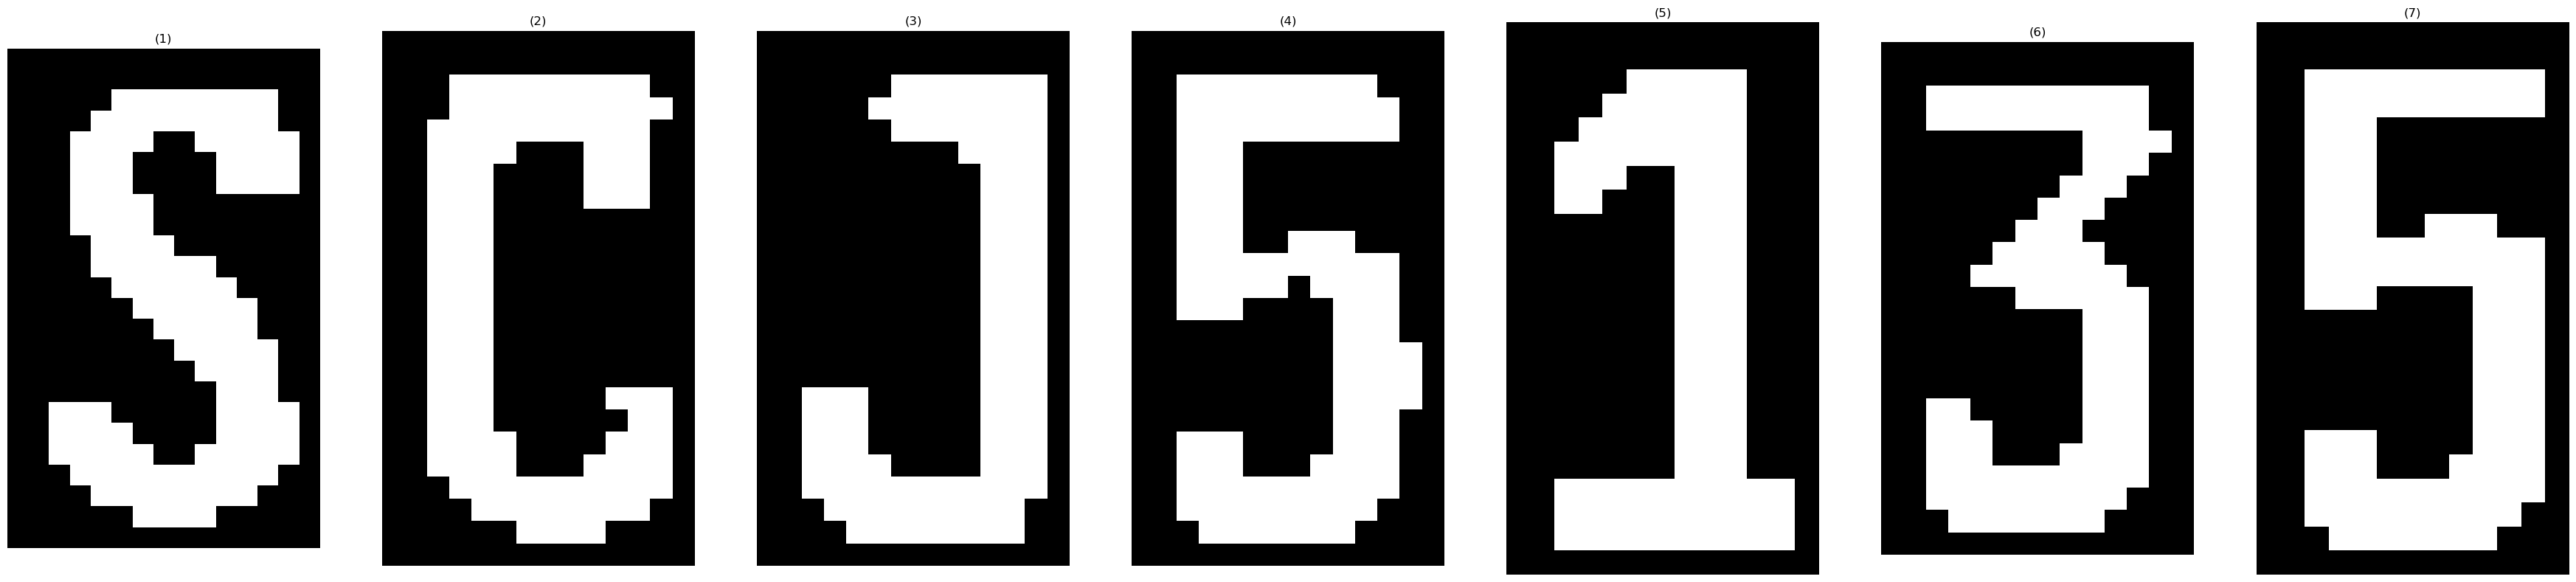

SCJ5J35
83.jpg


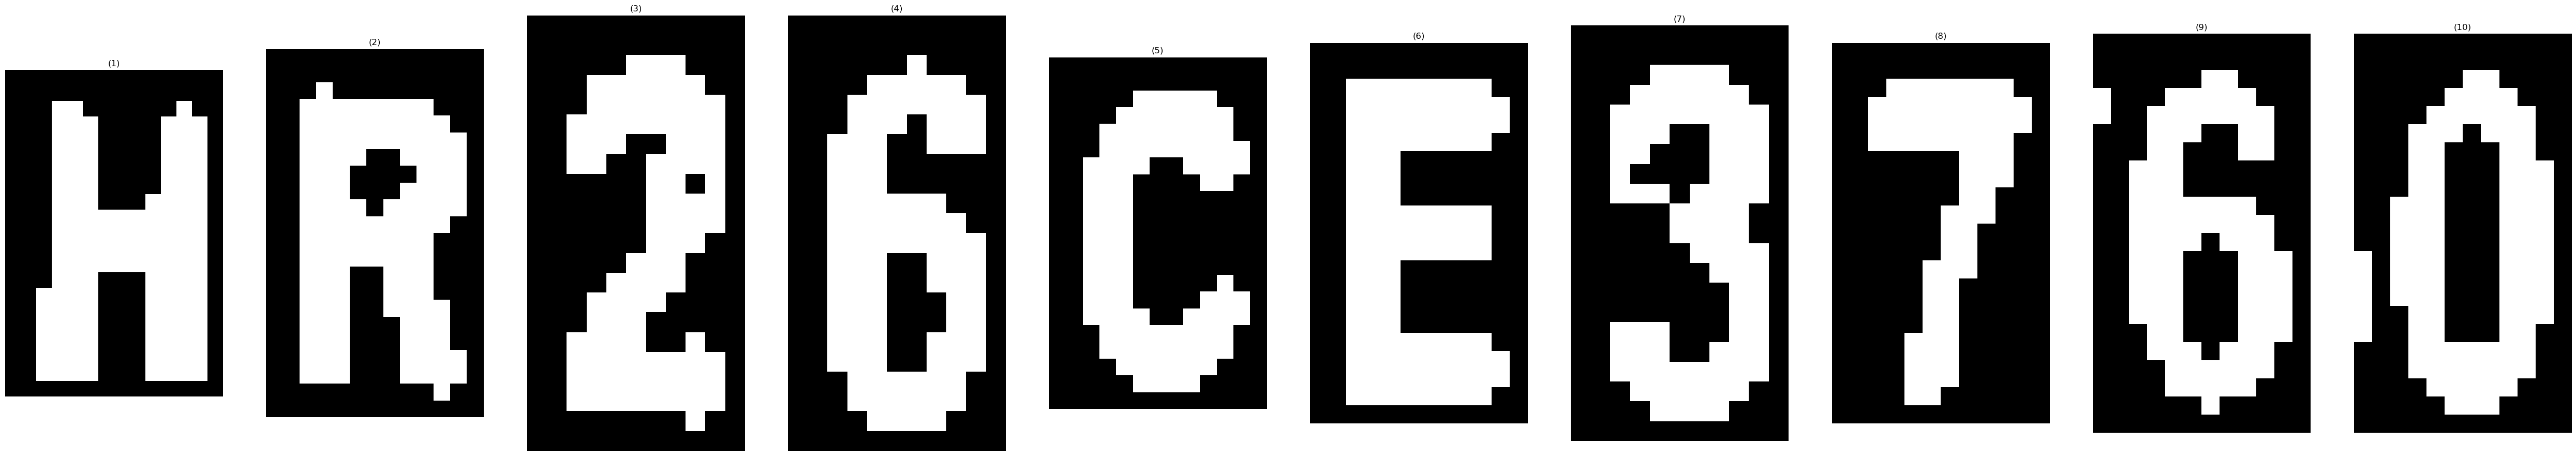

BR26CE3760
85.png


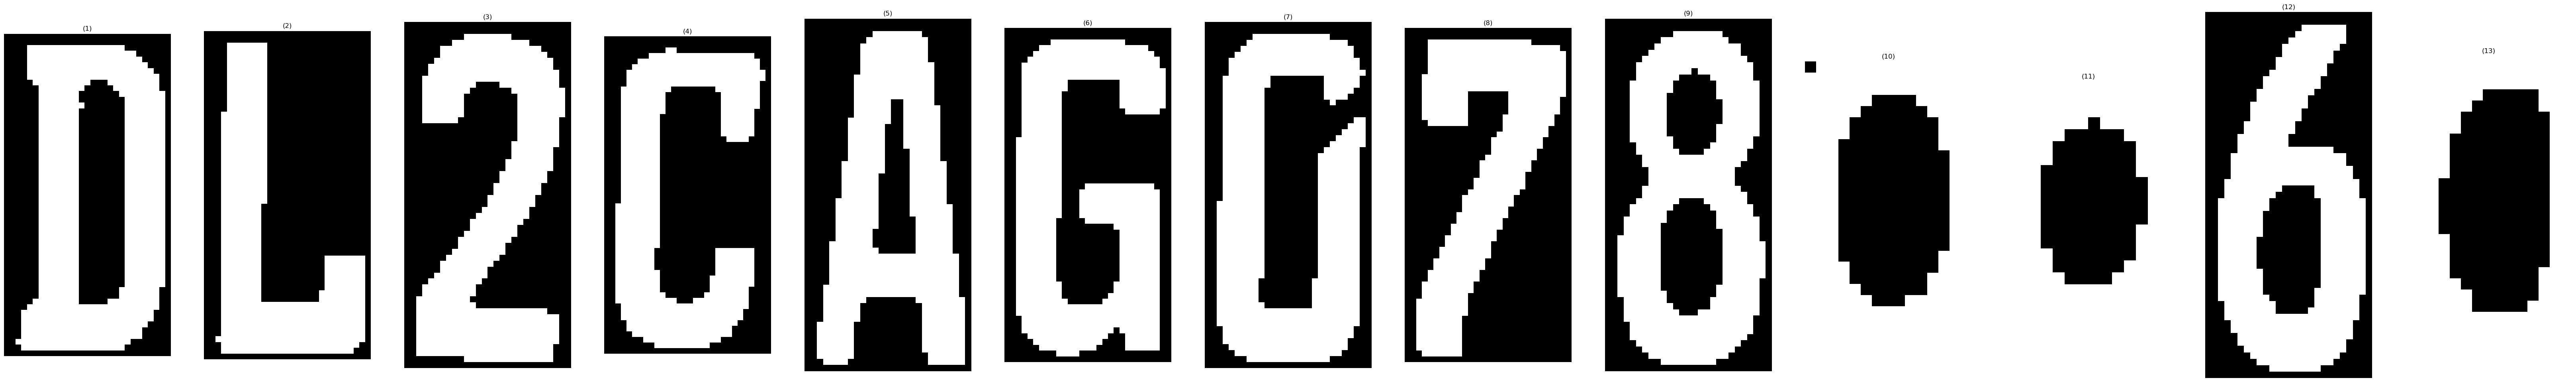

BL2CA6078UD6U
94.jpg


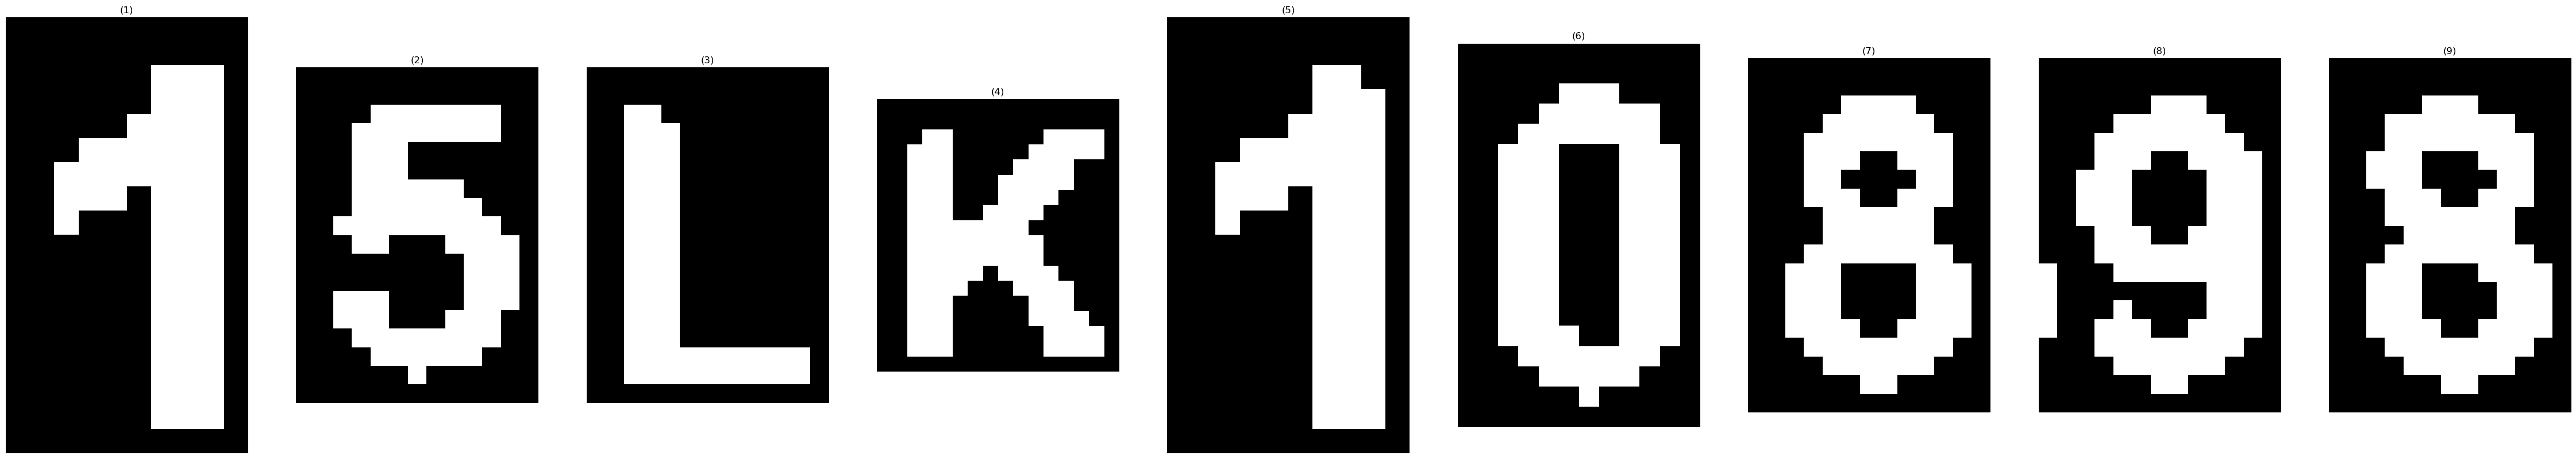

16LK10398
95.JPG


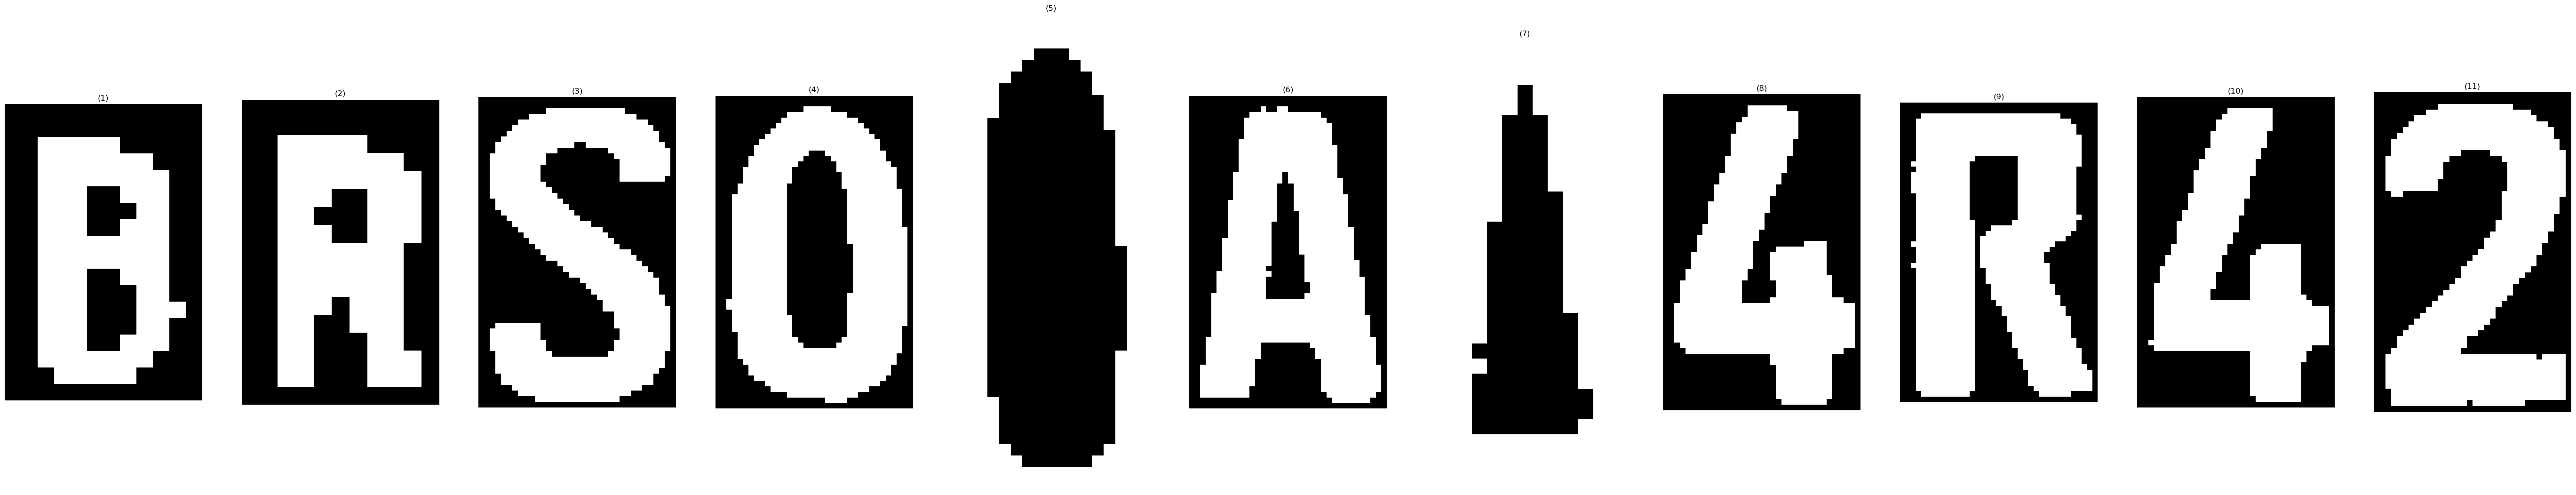

8RS0HAM4RA2
96.JPG


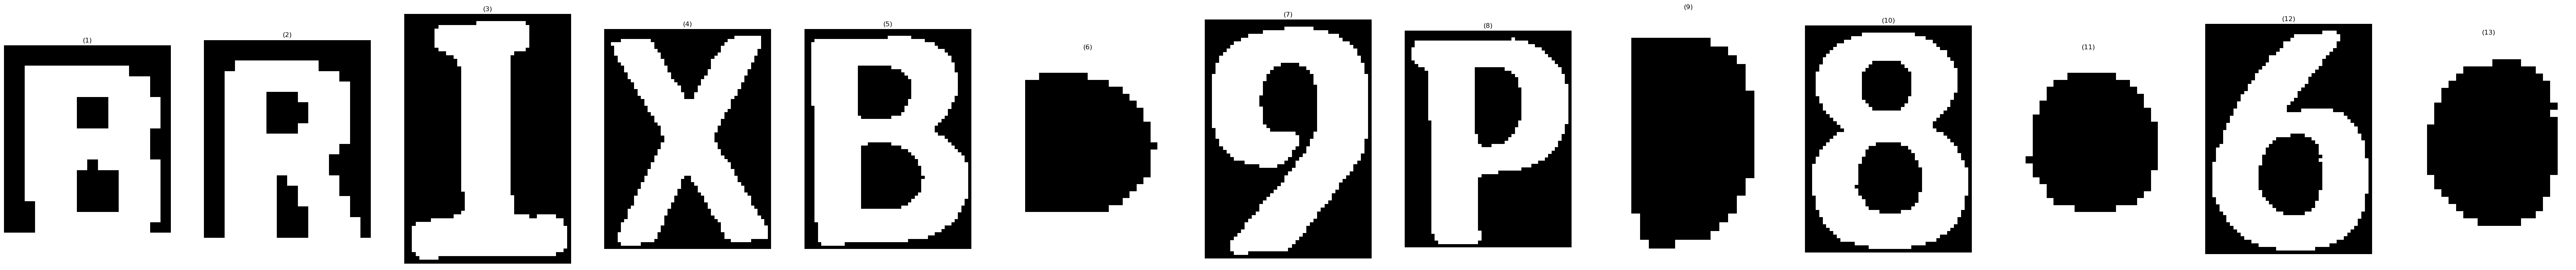

8RIXBH9PH8H6H
99.JPG


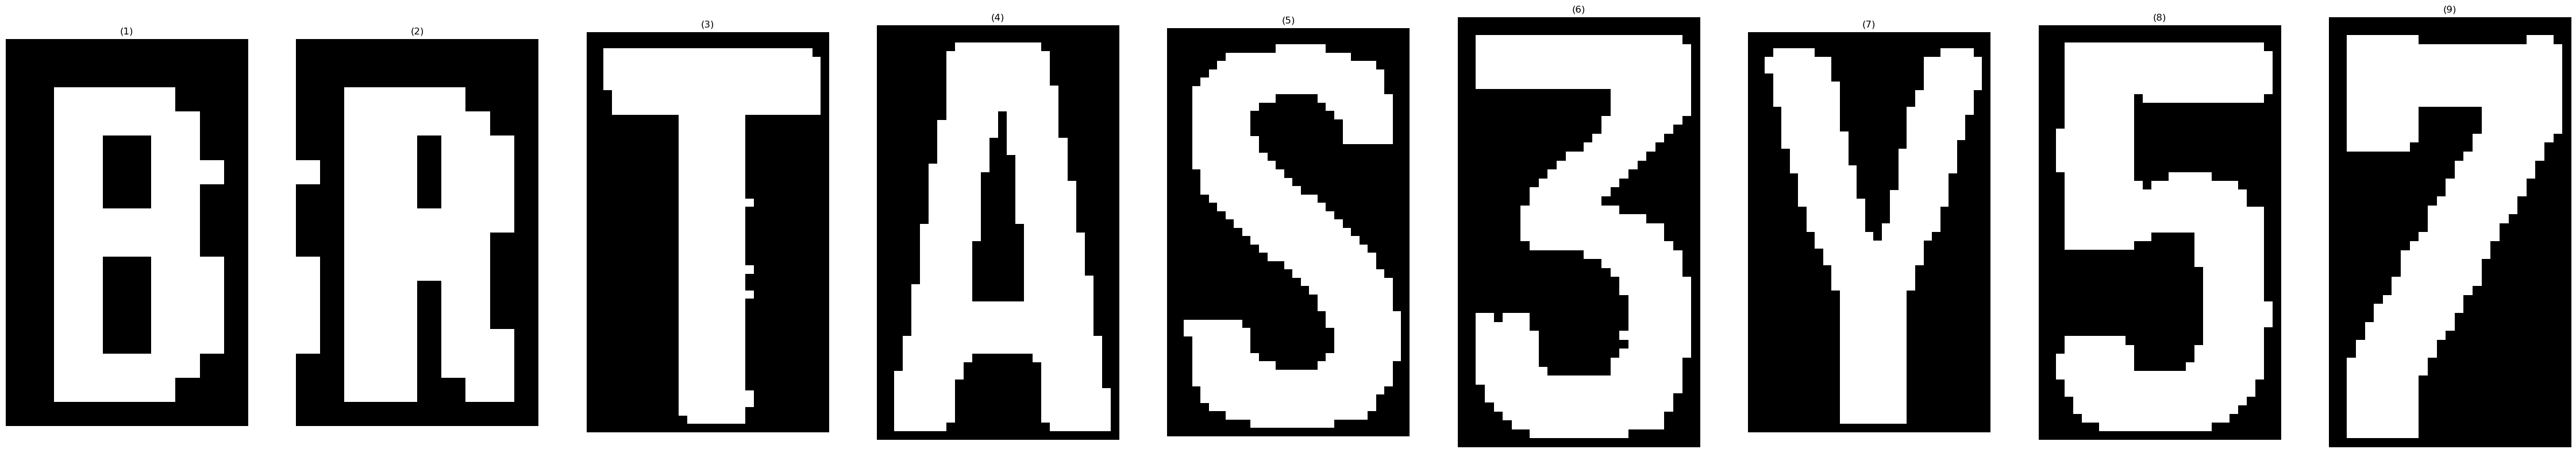

88TAS3Y57


In [156]:
ignoreImage=[ '10.jpg','15.JPG','48.JPG','50.JPG','51.JPG','78.jpg','89.JPG','90.JPG','19.jpg','30.JPG', '62.JPG', '64.JPG','66.JPG','77.jpg','79.jpg','87.JPG','108.JPG']
with open("results.txt","w") as f:
    f.write('Car   Knn Result                 Expected Result \n')
    for car,car_file_name in cars.items():
        if car_file_name not in ignoreImage and car_file_name not in ignoreFromCropp:
            car_image = cv2.imread("./test_dataset/images/"+car_file_name)
            # show_images([car_image], ["Input Image"])
            print(car_file_name)
            cars_image_cropped = crop_image(car_image) 
            if len(cars_image_cropped)>0:
                # show_images([cars_image_cropped] , ["Car Image Cropped"])
                car_image_rotated = rotate_image(cars_image_cropped)
                # show_images([car_image_rotated] , ["Car Image Rotated"])

                chars = segment_Character(car_image_rotated)
                # show_images(chars)
                data2=""
                show_images(chars)
                for img in chars:
                    # print(img)
                    new_img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_AREA)
                    new_img = new_img.reshape((1,IMG_WIDTH*IMG_HEIGHT))
                    # print(new_img.shape)
                    y_prediction = knn_default.predict(new_img)
                    # print(digitLetter[int(y_prediction)])
                    data2+=digitLetter[int(y_prediction)]
                print(data2)
                # textWrite="Car "+car+" KNN Result "+data2+" Expected Result "+test_plates[car]+'\n'
                textWrite=car+"     "+data2+"          "+test_plates[car]+'\n'
                f.write(textWrite)
            else:
                ignoreFromCropp.append(car_file_name)

        
        